# Load Data

## Main Code

In [27]:
import pandas as pd
df = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/snowflake_v5.2_pre_ts.csv')
len(df)

7795061

In [29]:
# all cols global

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

print("="*50)
print("LOADING DATA")
print("="*50)

df = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/snowflake_v5.2_pre_ts.csv')
df.head(2)
df['PO_CREATED_DATE'] = pd.to_datetime(df['PO_CREATED_DATE'], format = '%Y%m%d')
# Celing the Date value to first of each month
df['PO_CREATED_DATE'] = df['PO_CREATED_DATE'].dt.to_period('M').dt.to_timestamp()

print(f"Raw data: {len(df):,} rows | Total Purchases: {df['ORDERED_QUANTITY'].sum():,.0f}")

print("="*50)
print("Starting creation of Categorical Features")
print("="*50)
# Fill missing categorical values
cat_cols = [
    'REGION', 'COUNTRY', 'SALES_ORG_NAME', 'FABRIC_TYPE','SEASON_CONSOLIDATION',
    'MARKET_SEGMENT', 'GENDER', 'DIVISION_NAME', 'SPORT_UPDATED', 'SILHOUETTE_UPDATED'
]

for col in cat_cols:
    if col in df.columns:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            print(f"Filling {null_count:,} NULLs in {col}")
            df[col] = df[col].fillna('Unknown')


print("="*50)
print("Starting to Aggregate Data")
print("="*50)

# AGGREGATE TO SEGMENT LEVEL (ALL CATEGORICAL FEATURES)

group_cols = [
    'PO_CREATED_DATE', 'REGION', 'COUNTRY', 'SALES_ORG_NAME',
    'FABRIC_TYPE', 'SEASON_CONSOLIDATION', 'MARKET_SEGMENT', 'GENDER',
    'DIVISION_NAME', 'SPORT_UPDATED', 'SILHOUETTE_UPDATED'
]

# Keep only columns that exist
group_cols = [col for col in group_cols if col in df.columns]

df_segments = df.groupby(group_cols)['ORDERED_QUANTITY'].sum().reset_index()
ts_keys = [col for col in group_cols if col != 'PO_CREATED_DATE']
df_segments = df_segments.sort_values(ts_keys + ['PO_CREATED_DATE'])

print(f"Segment data: {len(df_segments):,} rows | Total Purchases: {df_segments['ORDERED_QUANTITY'].sum():,.0f}")

print("="*50)
print("Verifying Data Loss")
print("="*50)

# Verify no data loss
original_total = df['ORDERED_QUANTITY'].sum()
segment_total = df_segments['ORDERED_QUANTITY'].sum()
data_loss_pct = abs(original_total - segment_total) / original_total * 100

if data_loss_pct < 1:
    print(f"✓ Data preserved ({data_loss_pct:.3f}% difference)")
else:
    print(f"⚠ Warning: {data_loss_pct:.2f}% data loss")

print("="*50)
print("Capping Outlier Values")
print("="*50)

# OUTLIER HANDLING
train_mask = df_segments['PO_CREATED_DATE'] < '2025-01-01'
cap_q = 0.995
cap_value = df_segments.loc[train_mask, 'ORDERED_QUANTITY'].quantile(cap_q)
print(f"Outlier cap ({cap_q}): {cap_value:,.0f}")

df_segments['ORDERED_QUANTITY'] = df_segments['ORDERED_QUANTITY'].clip(lower=0, upper=cap_value)


print("="*50)
print("Solving December Missing Values")
print("="*50)

# FIX MISSING PART OF DECEMBER 2025
mask_dec_24 = (df_segments['PO_CREATED_DATE'].dt.year == 2024) & \
              (df_segments['PO_CREATED_DATE'].dt.month == 12)

fixed_dec_25 = df_segments[mask_dec_24].copy()

# 2. Shift dates to Dec 2025
fixed_dec_25['PO_CREATED_DATE'] = fixed_dec_25['PO_CREATED_DATE'] + pd.DateOffset(years=1)

# 3. Apply Growth (Assume 6%)
fixed_dec_25['ORDERED_QUANTITY'] = fixed_dec_25['ORDERED_QUANTITY'] * 1.06
# 4. Append to clean_data
df_segments = pd.concat([df_segments, fixed_dec_25], axis=0, ignore_index=True)
df_segments = df_segments.sort_values(group_cols + ['PO_CREATED_DATE']).reset_index(drop=True)


print("="*50)
print("Create Numeric Lags")
print("="*50)

# FEATURE ENGINEERING
# Time features
df_segments['month'] = df_segments['PO_CREATED_DATE'].dt.month
df_segments['quarter'] = df_segments['PO_CREATED_DATE'].dt.quarter
df_segments['year'] = df_segments['PO_CREATED_DATE'].dt.year
df_segments['month_sin'] = np.sin(2 * np.pi * df_segments['month'] / 12)
df_segments['month_cos'] = np.cos(2 * np.pi * df_segments['month'] / 12)

min_date = df_segments['PO_CREATED_DATE'].min()
#df_segments['months_since_start'] = ((df_segments['PO_CREATED_DATE'] - min_date).dt.days / 30.44).astype(int)


# Lag features (by segment)
print("Creating lag features...")
for lag in [1, 2, 3, 6, 12, 24, 36]:
    df_segments[f'lag_{lag}'] = df_segments.groupby(ts_keys)['ORDERED_QUANTITY'].shift(lag)

# Rolling features (by segment)
print("Creating rolling features...")
for window in [3, 6, 12]:
    df_segments[f'rollmean_{window}'] = (
        df_segments.groupby(ts_keys)['ORDERED_QUANTITY']
        .transform(lambda x: x.shift(1).rolling(window).mean())
    )

## EWM features (by segment)
#print("Creating EWM features...")
#for span in [3, 6]:
#    df_segments[f'ewm_{span}'] = (
#        df_segments.groupby(ts_keys)['ORDERED_QUANTITY']
#        .transform(lambda x: x.shift(1).ewm(span=span).mean())
#    )

#print("Creating Momentum features...")
## Momentum features
#df_segments['momentum_3m'] = df_segments['lag_1'] - df_segments['lag_3']
#df_segments['momentum_12m'] = df_segments['lag_1'] - df_segments['lag_12']
#df_segments['yoy_change'] = df_segments['lag_1'] - df_segments['lag_12']


print("Filling Missing values with Others...")
# Fill missing values
for col in ts_keys:
    df_segments[col] = df_segments[col].fillna('Other')
num_cols = df_segments.select_dtypes(include=[np.number]).columns
df_segments[num_cols] = df_segments[num_cols].fillna(0)

print(f"Features created: {len(df_segments.columns)}")

print("="*50)
print("Create Train/Test split datasets")
print("="*50)

# TRAIN-TEST SPLIT
split_date = '2025-01-01'
train = df_segments[df_segments['PO_CREATED_DATE'] < split_date].copy()
test = df_segments[df_segments['PO_CREATED_DATE'] >= split_date].copy()

print(f"Train: {len(train):,} rows ({train['PO_CREATED_DATE'].min()} to {train['PO_CREATED_DATE'].max()})")
print(f"Test:  {len(test):,} rows ({test['PO_CREATED_DATE'].min()} to {test['PO_CREATED_DATE'].max()})")

drop_cols = ['ORDERED_QUANTITY', 'PO_CREATED_DATE']
X_train = train.drop(columns=drop_cols)
y_train = train['ORDERED_QUANTITY']
X_test = test.drop(columns=drop_cols)
y_test = test['ORDERED_QUANTITY']

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


print("="*50)
print("Encoding Categories")
print("="*50)

category_mapping = {}

cat_features = X_train.select_dtypes(include='object').columns.tolist()
print(f"Categorical features to encode: {len(cat_features)}")

for col in cat_features:
    
    # Step 1 — convert train to category
    X_train[col] = X_train[col].astype('category')
    
    # Step 2 — extract categories
    categories = X_train[col].cat.categories
    
    # Step 3 — store mapping
    category_mapping[col] = categories
    
    # Step 4 — apply mapping to X_test
    X_test[col] = pd.Categorical(X_test[col], categories=categories)
    
    # Step 5 — encode
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes
    
    # Step 6 — unseen categories → -1
    X_test[col] = X_test[col].fillna(-1).astype(int)



LOADING DATA
Raw data: 7,795,061 rows | Total Purchases: 1,621,921,047
Starting creation of Categorical Features
Filling 692 NULLs in SPORT_UPDATED
Starting to Aggregate Data
Segment data: 106,826 rows | Total Purchases: 1,621,921,047
Verifying Data Loss
✓ Data preserved (0.000% difference)
Capping Outlier Values
Outlier cap (0.995): 525,473
Solving December Missing Values
Create Numeric Lags
Creating lag features...
Creating rolling features...
Filling Missing values with Others...
Features created: 25
Create Train/Test split datasets
Train: 97,886 rows (2008-08-01 00:00:00 to 2024-12-01 00:00:00)
Test:  9,579 rows (2025-01-01 00:00:00 to 2025-12-01 00:00:00)
Encoding Categories
Categorical features to encode: 8


In [30]:
# TRAIN MODEL
params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': 7,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'random_state': 42
}

print("\nTraining model...")
model = lgb.LGBMRegressor(**params, n_estimators=300)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]
)

print(f"Model trained. Best iteration: {model.best_iteration_}")


y_pred = np.maximum(model.predict(X_test), 0)
test['predicted'] = y_pred



Training model...
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[156]	valid_0's l1: 7171.74
Model trained. Best iteration: 156


In [31]:
# Train metrics
y_train_pred = np.maximum(model.predict(X_train), 0)
train['predicted'] = y_train_pred
train_agg = train.groupby('PO_CREATED_DATE').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
train_wape = np.abs(train_agg['ORDERED_QUANTITY'] - train_agg['predicted']).sum() / train_agg['ORDERED_QUANTITY'].sum() * 100

# Test metrics
test_agg = test.groupby('PO_CREATED_DATE').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
test_mae = mean_absolute_error(test_agg['ORDERED_QUANTITY'], test_agg['predicted'])
test_rmse = np.sqrt(mean_squared_error(test_agg['ORDERED_QUANTITY'], test_agg['predicted']))
test_wape = np.abs(test_agg['ORDERED_QUANTITY'] - test_agg['predicted']).sum() / test_agg['ORDERED_QUANTITY'].sum() * 100

print("\n" + "="*70)
print("MODEL PERFORMANCE (Monthly Aggregate)")
print("="*70)
print(f"Train WAPE: {train_wape:.2f}%  |  Test WAPE: {test_wape:.2f}%")
print(f"Test MAE:   {test_mae:,.0f}")
print(f"Test RMSE:  {test_rmse:,.0f}")
print(f"Accuracy:   {100 - test_wape:.2f}%")

if test_wape < train_wape * 1.5:
    print("Status:      Good generalization")
else:
    print("Status:      Check for overfitting")
print("="*70)


# Feature importance
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features:")
print(feat_imp.head(15).to_string(index=False))

# DRILL-DOWN ANALYSIS
print("\n" + "="*70)
print("DRILL-DOWN: 2025 Performance")
print("="*70)


MODEL PERFORMANCE (Monthly Aggregate)
Train WAPE: 10.80%  |  Test WAPE: 14.58%
Test MAE:   1,265,542
Test RMSE:  1,577,484
Accuracy:   85.42%
Status:      Good generalization

Top 15 Features:
      Feature  Importance
        lag_1         755
       lag_12         750
         year         658
  rollmean_12         634
        lag_6         590
        lag_2         582
       lag_24         581
   rollmean_6         571
       lag_36         553
        lag_3         542
   rollmean_3         538
        month         415
    month_cos         285
SPORT_UPDATED         277
    month_sin         262

DRILL-DOWN: 2025 Performance


In [32]:

# By Region
region_2023 = test[
    (test['PO_CREATED_DATE'] >= '2025-01-01') & (test['PO_CREATED_DATE'] < '2026-01-01')
].groupby('REGION').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
region_2023['error_%'] = abs(region_2023['ORDERED_QUANTITY'] - region_2023['predicted']) / region_2023['ORDERED_QUANTITY'] * 100
region_2023 = region_2023.sort_values('ORDERED_QUANTITY', ascending=False)

print("\nBy Region:")
print(region_2023.to_string(index=False, float_format=lambda x: f'{x:,.0f}' if abs(x) > 100 else f'{x:.2f}'))

# By Country (Top 5)
if 'COUNTRY' in test.columns:
    country_2023 = test[
        (test['PO_CREATED_DATE'] >= '2025-01-01') & (test['PO_CREATED_DATE'] < '2026-01-01')
    ].groupby('COUNTRY').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
    country_2023['error_%'] = abs(country_2023['ORDERED_QUANTITY'] - country_2023['predicted']) / country_2023['ORDERED_QUANTITY'] * 100
    country_2023 = country_2023.sort_values('ORDERED_QUANTITY', ascending=False).head(5)
    
    print("\nBy Country (Top 5):")
    print(country_2023.to_string(index=False, float_format=lambda x: f'{x:,.0f}' if abs(x) > 100 else f'{x:.2f}'))

# By SILHOUETTE_UPDATED
sil_2023 = test[
    (test['PO_CREATED_DATE'] >= '2025-01-01') & (test['PO_CREATED_DATE'] < '2026-01-01')
].groupby('SILHOUETTE_UPDATED').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
sil_2023['error_%'] = abs(sil_2023['ORDERED_QUANTITY'] - sil_2023['predicted']) / sil_2023['ORDERED_QUANTITY'] * 100
sil_2023 = sil_2023.sort_values('ORDERED_QUANTITY', ascending=False)

print("\nBy SILHOUETTE_UPDATED:")
print(sil_2023.to_string(index=False, float_format=lambda x: f'{x:,.0f}' if abs(x) > 100 else f'{x:.2f}'))

# By SPORT_UPDATED (Top 5)
if 'SPORT_UPDATED' in test.columns:
    sport_2023 = test[
        (test['PO_CREATED_DATE'] >= '2025-01-01') & (test['PO_CREATED_DATE'] < '2026-01-01')
    ].groupby('SPORT_UPDATED').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
    sport_2023['error_%'] = abs(sport_2023['ORDERED_QUANTITY'] - sport_2023['predicted']) / sport_2023['ORDERED_QUANTITY'] * 100
    sport_2023 = sport_2023.sort_values('ORDERED_QUANTITY', ascending=False).head(5)
    
    print("\nBy SPORT_UPDATED (Top 5):")
    print(sport_2023.to_string(index=False, float_format=lambda x: f'{x:,.0f}' if abs(x) > 100 else f'{x:.2f}'))


By Region:
          REGION  ORDERED_QUANTITY  predicted  error_%
   North America        71,027,820 70,671,173     0.50
Emerging Markets        14,680,080 15,232,567     3.76
            EMEA        12,960,585 11,505,954    11.22
           Japan         5,482,144  5,089,453     7.16

By Country (Top 5):
            COUNTRY  ORDERED_QUANTITY  predicted  error_%
           US : USA        71,592,260 70,993,565     0.84
GB : United Kingdom        12,800,862 11,340,609    11.41
         JP : Japan         5,482,144  5,089,453     7.16
        CA : Canada         5,046,850  4,713,386     6.61
     HK : Hong Kong         3,841,919  3,759,227     2.15

By SILHOUETTE_UPDATED:
SILHOUETTE_UPDATED  ORDERED_QUANTITY  predicted  error_%
              5950        50,719,670 48,826,160     3.73
             Other        35,661,366 33,277,774     6.68
               940         6,957,807  7,524,933     8.15
              3930         3,783,835  4,823,653    27.48
               920         3,602,17

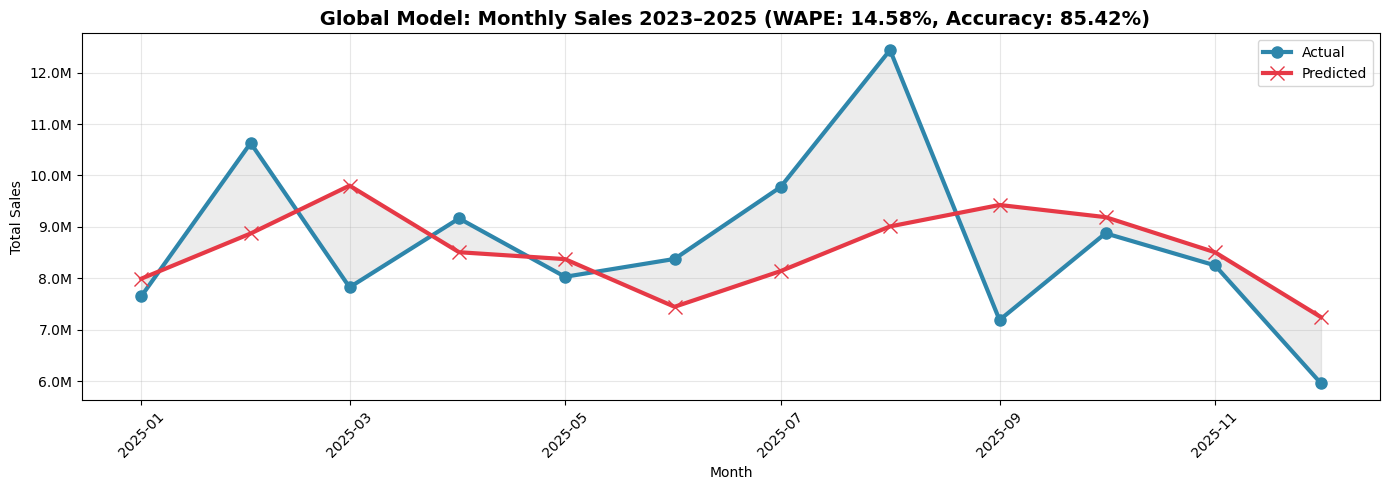

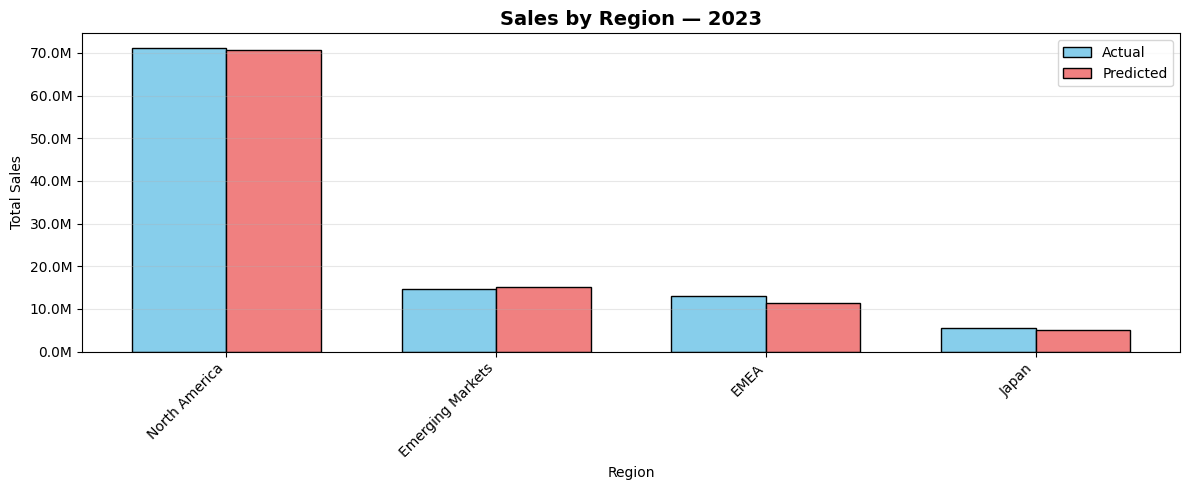

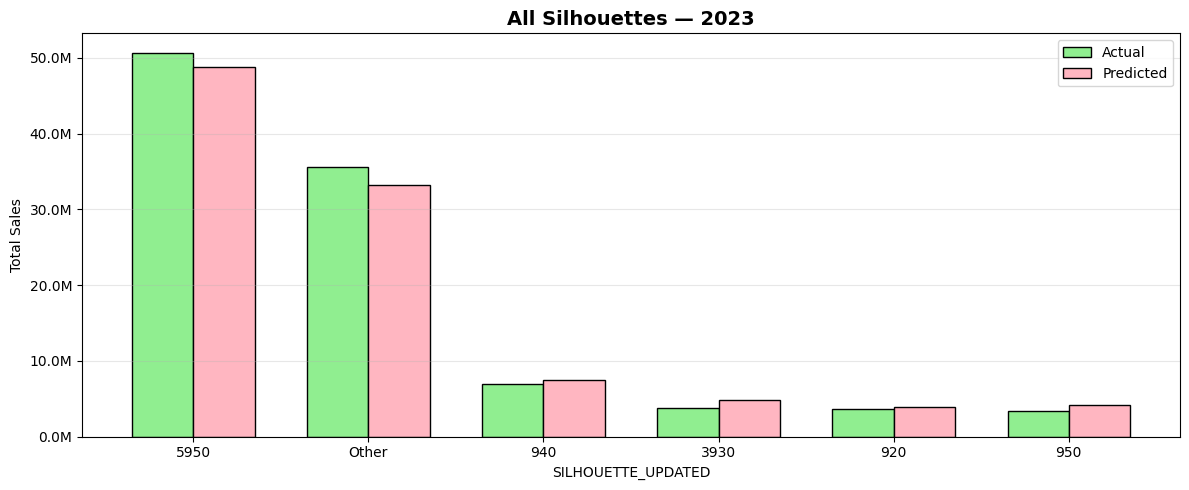

In [33]:
# VISUALIZATION


def millions_fmt(x, pos):
    return f'{x/1_000_000:.1f}M'

# Plot 1: Monthly Aggregate
plt.figure(figsize=(14, 5))
plt.plot(test_agg['PO_CREATED_DATE'], test_agg['ORDERED_QUANTITY'], 
         label='Actual', linewidth=3, color='#2E86AB', marker='o', markersize=8)
plt.plot(test_agg['PO_CREATED_DATE'], test_agg['predicted'], 
         label='Predicted', linewidth=3, color='#E63946', marker='x', markersize=10)
plt.fill_between(test_agg['PO_CREATED_DATE'], test_agg['ORDERED_QUANTITY'], test_agg['predicted'], alpha=0.15, color='gray')
plt.title(f" Global Model: Monthly Sales 2023–2025 (WAPE: {test_wape:.2f}%, Accuracy: {100-test_wape:.2f}%)", 
          fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_fmt))
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: By Region
plt.figure(figsize=(12, 5))
x = np.arange(len(region_2023))
width = 0.35
plt.bar(x - width/2, region_2023['ORDERED_QUANTITY'], width, label='Actual', color='skyblue', edgecolor='black')
plt.bar(x + width/2, region_2023['predicted'], width, label='Predicted', color='lightcoral', edgecolor='black')
plt.title('Sales by Region — 2023', fontsize=14, fontweight='bold')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.xticks(x, region_2023['REGION'], rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_fmt))
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: By SILHOUETTE_UPDATED
plt.figure(figsize=(12, 5))
x = np.arange(len(sil_2023))
plt.bar(x - width/2, sil_2023['ORDERED_QUANTITY'], width, label='Actual', color='#90EE90', edgecolor='black')
plt.bar(x + width/2, sil_2023['predicted'], width, label='Predicted', color='#FFB6C1', edgecolor='black')
plt.title('All Silhouettes — 2023', fontsize=14, fontweight='bold')
plt.xlabel('SILHOUETTE_UPDATED')
plt.ylabel('Total Sales')
plt.xticks(x, sil_2023['SILHOUETTE_UPDATED'])
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_fmt))
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()





In [34]:
import pickle
pickle.dump(model, open('/home/azureuser/cloudfiles/code/Users/vlavanga/data/models/model_lgbm.pkl', 'wb'))
with open('/home/azureuser/cloudfiles/code/Users/vlavanga/data/models/model_lgbm.pkl','rb') as file:
    model = pickle.load(file)

In [35]:
X_test.head(1)

,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,month,quarter,...,lag_1,lag_2,lag_3,lag_6,lag_12,lag_24,lag_36,rollmean_3,rollmean_6,rollmean_12
97886,0,3,6,0,0,3,18,5,1,1,...,1300.0,1500.0,4800.0,3000.0,0.0,0.0,0.0,2533.333333,2516.666667,0.0


In [36]:
cat_features = ['REGION',
 'COUNTRY',
 'SALES_ORG_NAME',
 'FABRIC_TYPE',
 'SEASON_CONSOLIDATION',
 'DIVISION_NAME',
 'SPORT_UPDATED',
 'SILHOUETTE_UPDATED']

In [38]:
import shap

explainer = shap.TreeExplainer(model)

shap_future = explainer.shap_values(X_test)

In [16]:
def summarize_shap(shap_values_row, feature_names, top_k=3):
    shap_map = dict(zip(feature_names, shap_values_row))

    # Top K positive contributors
    top_positive = [
        (f, v) for f, v in shap_map.items() if v > 0
    ]
    top_positive = sorted(top_positive, key=lambda x: x[1], reverse=True)[:top_k]

    # Top K negative contributors
    top_negative = [
        (f, v) for f, v in shap_map.items() if v < 0
    ]
    top_negative = sorted(top_negative, key=lambda x: x[1])[:top_k]

    # Magnitude score
    shap_magnitude = sum(abs(v) for v in shap_map.values())

    return {
        "top_positive": {f: float(v) for f, v in top_positive},
        "top_negative": {f: float(v) for f, v in top_negative},
        "shap_magnitude": float(shap_magnitude)
    }


In [ ]:
import json

shap_summary_list = []

for i in range(len(X_test)):
    row_shap = shap_future[i]                     # SHAP values for row i
    summary = summarize_shap(row_shap, X_test.columns)
    shap_summary_list.append(summary)

X_test["shap_summary"] = shap_summary_list

In [ ]:
X_test.insert(loc=0, column='PO_CREATED_DATE', value=test['PO_CREATED_DATE'])

In [ ]:
shap_df = pd.DataFrame(shap_future, columns=X_test.columns)
shap_df["PO_CREATED_DATE"] = test['PO_CREATED_DATE'].reset_index(drop=True)


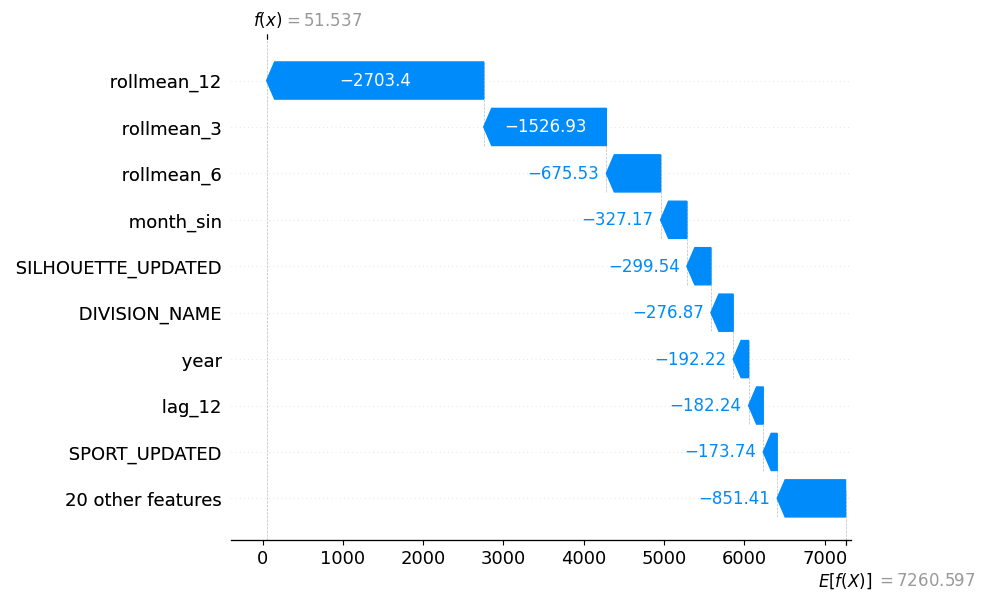

In [ ]:
row = shap_df[shap_df["PO_CREATED_DATE"] == "2025-12-01"].iloc[0]

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    row[X_test.columns].values,
    test[test['PO_CREATED_DATE'] == "2025-12-01"].iloc[0]
)

## Forecast Future

In [45]:
mask_dataset = (df_segments['PO_CREATED_DATE'].dt.year == 2025)

In [46]:
df_main = df_segments[(df_segments['PO_CREATED_DATE'] >= '2025-01-01') & (df_segments['PO_CREATED_DATE'] <= '2025-12-01')].copy()
df_main = df_main[group_cols + ['ORDERED_QUANTITY']]

df_main_3 = df_segments[(df_segments['PO_CREATED_DATE'] >= '2023-01-01') & (df_segments['PO_CREATED_DATE'] <= '2025-12-01')].copy()
df_2026 = df_segments[mask_dataset].copy()
df_2026 = df_2026[group_cols + ['ORDERED_QUANTITY']]
df_2026['ORDERED_QUANTITY'] = 0
df_2026['PO_CREATED_DATE'] = df_2026['PO_CREATED_DATE'] + pd.DateOffset(years=1)

df_2027 = df_segments[mask_dataset].copy()
df_2027 = df_2027[group_cols + ['ORDERED_QUANTITY']]
df_2027['ORDERED_QUANTITY'] = 0
df_2027['PO_CREATED_DATE'] = df_2027['PO_CREATED_DATE'] + pd.DateOffset(years=2)

df_2028 = df_segments[mask_dataset].copy()
df_2028 = df_2028[group_cols + ['ORDERED_QUANTITY']]
df_2028['ORDERED_QUANTITY'] = 0
df_2028['PO_CREATED_DATE'] = df_2028['PO_CREATED_DATE'] + pd.DateOffset(years=3)

Creating lag features...
Creating rolling features...
Features created: 25
Test:  9,579 rows (2026-01-01 00:00:00 to 2026-12-01 00:00:00)


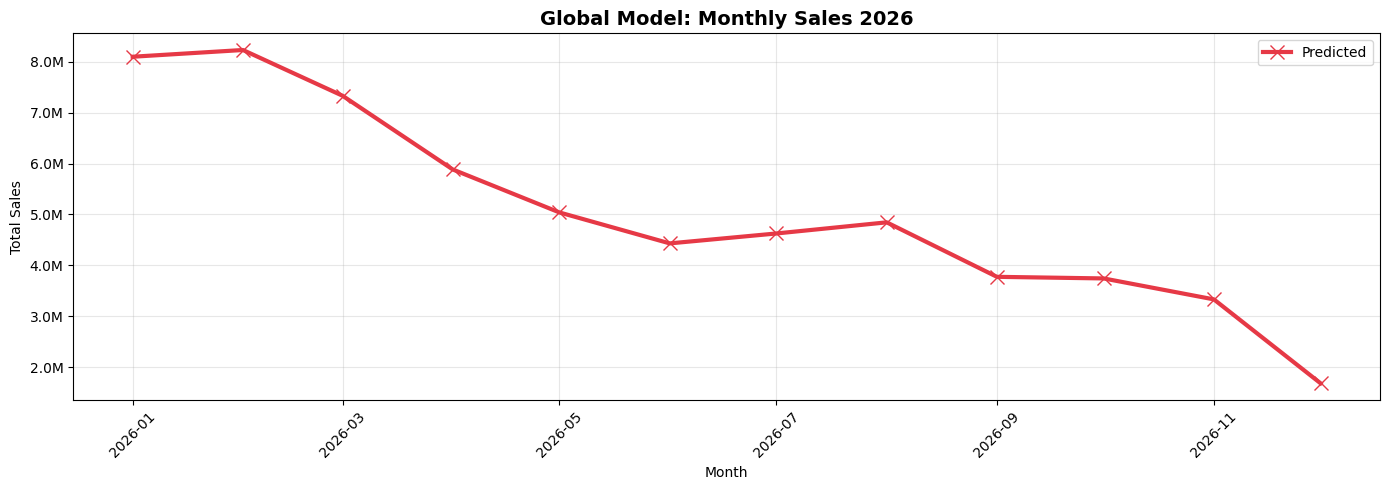

In [47]:
# Create Test 2026
test_2026 = pd.concat([df_main_3, df_2026], axis=0, ignore_index=True)
test_2026 = test_2026.sort_values(group_cols + ['PO_CREATED_DATE']).reset_index(drop=True)

# Time features
test_2026['month'] = test_2026['PO_CREATED_DATE'].dt.month
test_2026['quarter'] = test_2026['PO_CREATED_DATE'].dt.quarter
test_2026['year'] = test_2026['PO_CREATED_DATE'].dt.year
test_2026['month_sin'] = np.sin(2 * np.pi * test_2026['month'] / 12)
test_2026['month_cos'] = np.cos(2 * np.pi * test_2026['month'] / 12)

min_date = test_2026['PO_CREATED_DATE'].min()
#test_2026['months_since_start'] = ((test_2026['PO_CREATED_DATE'] - min_date).dt.days / 30.44).astype(int)

# Lag features (by segment)
print("Creating lag features...")
for lag in [1, 2, 3, 6, 12, 24, 36]:
    test_2026[f'lag_{lag}'] = test_2026.groupby(ts_keys)['ORDERED_QUANTITY'].shift(lag)

# Rolling features (by segment)
print("Creating rolling features...")
for window in [3, 6, 12]:
    test_2026[f'rollmean_{window}'] = (
        test_2026.groupby(ts_keys)['ORDERED_QUANTITY']
        .transform(lambda x: x.shift(1).rolling(window).mean())
    )

# EWM features (by segment)
#print("Creating EWM features...")
#for span in [3, 6]:
#    test_2026[f'ewm_{span}'] = (
#        test_2026.groupby(ts_keys)['ORDERED_QUANTITY']
#        .transform(lambda x: x.shift(1).ewm(span=span).mean())
#    )
#
## Momentum features
#test_2026['momentum_3m'] = test_2026['lag_1'] - test_2026['lag_3']
#test_2026['momentum_12m']= test_2026['lag_1'] - test_2026['lag_12']
#test_2026['yoy_change']  = test_2026['lag_1'] - test_2026['lag_12']

# Fill missing values
for col in ts_keys:
    test_2026[col] = test_2026[col].fillna('Unknown')
num_cols = test_2026.select_dtypes(include=[np.number]).columns
test_2026[num_cols] = test_2026[num_cols].fillna(0)

print(f"Features created: {len(test_2026.columns)}")

# TRAIN-TEST SPLIT


split_date = '2026-01-01'
test_2026_main = test_2026[test_2026['PO_CREATED_DATE'] >= split_date].copy()

print(f"Test:  {len(test_2026_main):,} rows ({test_2026_main['PO_CREATED_DATE'].min()} to {test_2026_main['PO_CREATED_DATE'].max()})")

drop_cols = ['ORDERED_QUANTITY', 'PO_CREATED_DATE']
X_test_2026 = test_2026_main.drop(columns=drop_cols)
y_test_2026 = test_2026_main['ORDERED_QUANTITY']

X_test_2026 = X_test_2026.reindex(columns=X_train.columns, fill_value=0)

for col, categories in category_mapping.items():
    X_test_2026[col] = pd.Categorical(X_test_2026[col], categories=categories).codes
    X_test_2026[col] = X_test_2026[col].replace({np.nan: -1}).astype(int)

# PREDICTIONS & EVALUATION
y_pred_2026 = np.maximum(model.predict(X_test_2026), 0)
test_2026_main['predicted'] = y_pred_2026

X_test_2026.insert(loc=0, column='PO_CREATED_DATE', value=test_2026_main['PO_CREATED_DATE'])

df_actual_2026 = test_2026_main[group_cols + ['ORDERED_QUANTITY']].copy()
df_actual_2026['ORDERED_QUANTITY'] = test_2026_main['predicted'].round()

test_agg_2026 = test_2026_main.groupby('PO_CREATED_DATE').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
# Plot 1: Monthly Aggregate
plt.figure(figsize=(14, 5))
plt.plot(test_agg_2026['PO_CREATED_DATE'], test_agg_2026['predicted'], 
         label='Predicted', linewidth=3, color='#E63946', marker='x', markersize=10)

#plt.fill_between(test_agg_2026['PO_CREATED_DATE'], test_agg_2026['ORDERED_QUANTITY'], test_agg_2026['predicted'], alpha=0.15, color='gray')
plt.title(f"Global Model: Monthly Sales 2026", fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_fmt))
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Creating lag features...
Creating rolling features...
Features created: 25
Test:  14,660 rows (2027-01-01 00:00:00 to 2027-12-01 00:00:00)


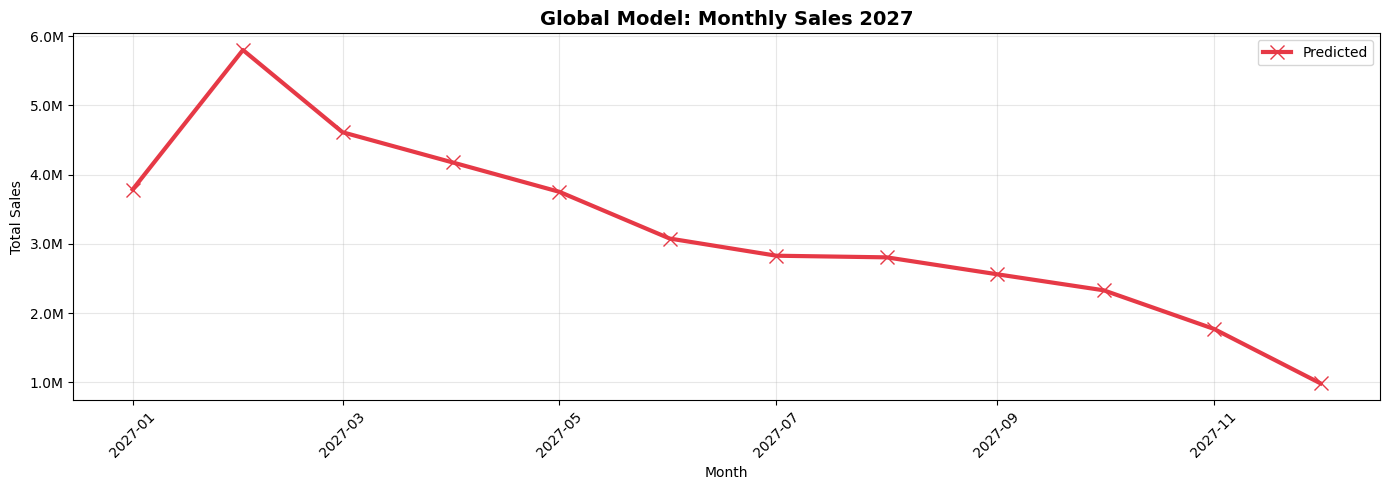

In [ ]:
# Start 2027
test_2027 = pd.concat([df_actual_2026, df_2027], axis=0, ignore_index=True)
test_2027 = test_2027.sort_values(group_cols + ['PO_CREATED_DATE']).reset_index(drop=True)

# FEATURE ENGINEERING
# Time features
test_2027['month'] = test_2027['PO_CREATED_DATE'].dt.month
test_2027['quarter'] = test_2027['PO_CREATED_DATE'].dt.quarter
test_2027['year'] = test_2027['PO_CREATED_DATE'].dt.year
test_2027['month_sin'] = np.sin(2 * np.pi * test_2027['month'] / 12)
test_2027['month_cos'] = np.cos(2 * np.pi * test_2027['month'] / 12)

min_date = test_2027['PO_CREATED_DATE'].min()
#test_2027['months_since_start'] = ((test_2027['PO_CREATED_DATE'] - min_date).dt.days / 30.44).astype(int)

# Lag features (by segment)
print("Creating lag features...")
for lag in [1, 2, 3, 6, 12]:
    test_2027[f'lag_{lag}'] = test_2027.groupby(ts_keys)['ORDERED_QUANTITY'].shift(lag)

# Rolling features (by segment)
print("Creating rolling features...")
for window in [3, 6, 12]:
    test_2027[f'rollmean_{window}'] = (
        test_2027.groupby(ts_keys)['ORDERED_QUANTITY']
        .transform(lambda x: x.shift(1).rolling(window).mean())
    )

## EWM features (by segment)
#print("Creating EWM features...")
#for span in [3, 6]:
#    test_2027[f'ewm_{span}'] = (
#        test_2027.groupby(ts_keys)['ORDERED_QUANTITY']
#        .transform(lambda x: x.shift(1).ewm(span=span).mean())
#    )
#
## Momentum features
#test_2027['momentum_3m'] = test_2027['lag_1'] - test_2027['lag_3']
#test_2027['momentum_12m']= test_2027['lag_1'] - test_2027['lag_12']
#test_2027['yoy_change']  = test_2027['lag_1'] - test_2027['lag_12']

# Fill missing values
for col in ts_keys:
    test_2027[col] = test_2027[col].fillna('Unknown')
num_cols = test_2027.select_dtypes(include=[np.number]).columns
test_2027[num_cols] = test_2027[num_cols].fillna(0)

print(f"Features created: {len(test_2027.columns)}")

# TRAIN-TEST SPLIT


split_date = '2027-01-01'
test_2027_main = test_2027[test_2027['PO_CREATED_DATE'] >= split_date].copy()

print(f"Test:  {len(test_2027_main):,} rows ({test_2027_main['PO_CREATED_DATE'].min()} to {test_2027_main['PO_CREATED_DATE'].max()})")

drop_cols = ['ORDERED_QUANTITY', 'PO_CREATED_DATE']
X_test_2027 = test_2027_main.drop(columns=drop_cols)
y_test_2027 = test_2027_main['ORDERED_QUANTITY']

X_test_2027 = X_test_2027.reindex(columns=X_train.columns, fill_value=0)

for col, categories in category_mapping.items():
    X_test_2027[col] = pd.Categorical(X_test_2027[col], categories=categories).codes
    X_test_2027[col] = X_test_2027[col].replace({np.nan: -1}).astype(int)

# PREDICTIONS & EVALUATION
y_pred_2027 = np.maximum(model.predict(X_test_2027), 0)
test_2027_main['predicted'] = y_pred_2027

X_test_2027.insert(loc=0, column='PO_CREATED_DATE', value=test_2027_main['PO_CREATED_DATE'])

df_actual_2027 = test_2027_main[group_cols + ['ORDERED_QUANTITY']].copy()
df_actual_2027['ORDERED_QUANTITY'] = test_2027_main['predicted'].round()
df_actual_2027.head()

test_agg_2027 = test_2027_main.groupby('PO_CREATED_DATE').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
# Plot 1: Monthly Aggregate
plt.figure(figsize=(14, 5))
plt.plot(test_agg_2027['PO_CREATED_DATE'], test_agg_2027['predicted'], 
         label='Predicted', linewidth=3, color='#E63946', marker='x', markersize=10)

#plt.fill_between(test_agg_2027['PO_CREATED_DATE'], test_agg_2027['ORDERED_QUANTITY'], test_agg_2027['predicted'], alpha=0.15, color='gray')
plt.title(f"Global Model: Monthly Sales 2027", fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_fmt))
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Creating lag features...
Creating rolling features...
Features created: 25
Test:  14,660 rows (2028-01-01 00:00:00 to 2028-12-01 00:00:00)


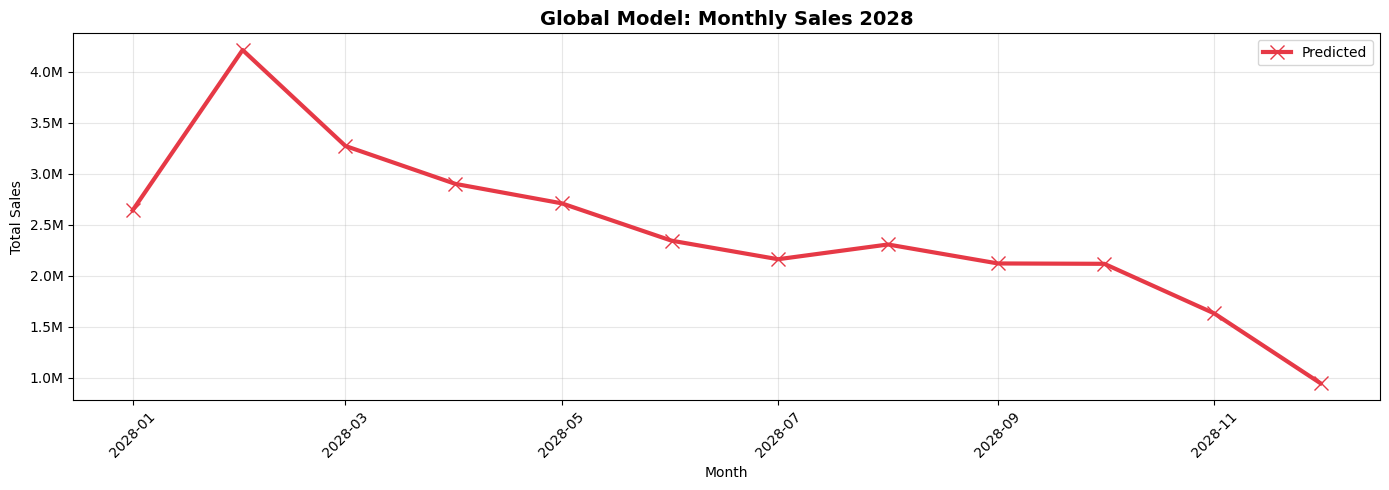

In [ ]:
# Start for 2028
test_2028 = pd.concat([df_actual_2027, df_2028], axis=0, ignore_index=True)
test_2028 = test_2028.sort_values(group_cols + ['PO_CREATED_DATE']).reset_index(drop=True)
test_2028

# FEATURE ENGINEERING


# Time features
test_2028['month'] = test_2028['PO_CREATED_DATE'].dt.month
test_2028['quarter'] = test_2028['PO_CREATED_DATE'].dt.quarter
test_2028['year'] = test_2028['PO_CREATED_DATE'].dt.year
test_2028['month_sin'] = np.sin(2 * np.pi * test_2028['month'] / 12)
test_2028['month_cos'] = np.cos(2 * np.pi * test_2028['month'] / 12)

min_date = test_2028['PO_CREATED_DATE'].min()
#test_2028['months_since_start'] = ((test_2028['PO_CREATED_DATE'] - min_date).dt.days / 30.44).astype(int)

# Lag features (by segment)
print("Creating lag features...")
for lag in [1, 2, 3, 6, 12]:
    test_2028[f'lag_{lag}'] = test_2028.groupby(ts_keys)['ORDERED_QUANTITY'].shift(lag)

# Rolling features (by segment)
print("Creating rolling features...")
for window in [3, 6, 12]:
    test_2028[f'rollmean_{window}'] = (
        test_2028.groupby(ts_keys)['ORDERED_QUANTITY']
        .transform(lambda x: x.shift(1).rolling(window).mean())
    )

# EWM features (by segment)
#print("Creating EWM features...")
#for span in [3, 6]:
#    test_2028[f'ewm_{span}'] = (
#        test_2028.groupby(ts_keys)['ORDERED_QUANTITY']
#        .transform(lambda x: x.shift(1).ewm(span=span).mean())
#    )
#
## Momentum features
#test_2028['momentum_3m'] = test_2028['lag_1'] - test_2028['lag_3']
#test_2028['momentum_12m']= test_2028['lag_1'] - test_2028['lag_12']
#test_2028['yoy_change']  = test_2028['lag_1'] - test_2028['lag_12']

# Fill missing values
for col in ts_keys:
    test_2028[col] = test_2028[col].fillna('Unknown')
num_cols = test_2028.select_dtypes(include=[np.number]).columns
test_2028[num_cols] = test_2028[num_cols].fillna(0)

print(f"Features created: {len(test_2028.columns)}")


# TRAIN-TEST SPLIT


split_date = '2028-01-01'
test_2028_main = test_2028[test_2028['PO_CREATED_DATE'] >= split_date].copy()

print(f"Test:  {len(test_2028_main):,} rows ({test_2028_main['PO_CREATED_DATE'].min()} to {test_2028_main['PO_CREATED_DATE'].max()})")

drop_cols = ['ORDERED_QUANTITY', 'PO_CREATED_DATE']
X_test_2028 = test_2028_main.drop(columns=drop_cols)
y_test_2028 = test_2028_main['ORDERED_QUANTITY']

X_test_2028 = X_test_2028.reindex(columns=X_train.columns, fill_value=0)

for col, categories in category_mapping.items():
    X_test_2028[col] = pd.Categorical(X_test_2028[col], categories=categories).codes
    X_test_2028[col] = X_test_2028[col].replace({np.nan: -1}).astype(int)

# PREDICTIONS & EVALUATION
y_pred_2028 = np.maximum(model.predict(X_test_2028), 0)
test_2028_main['predicted'] = y_pred_2028

X_test_2028.insert(loc=0, column='PO_CREATED_DATE', value=test_2028_main['PO_CREATED_DATE'])

df_actual_2028 = test_2028_main[group_cols + ['ORDERED_QUANTITY']].copy()
df_actual_2028['ORDERED_QUANTITY'] = test_2028_main['predicted'].round()
df_actual_2028.head()

test_agg_2028 = test_2028_main.groupby('PO_CREATED_DATE').agg({'ORDERED_QUANTITY': 'sum', 'predicted': 'sum'}).reset_index()
# Plot 1: Monthly Aggregate
plt.figure(figsize=(14, 5))
plt.plot(test_agg_2028['PO_CREATED_DATE'], test_agg_2028['predicted'], 
         label='Predicted', linewidth=3, color='#E63946', marker='x', markersize=10)

#plt.fill_between(test_agg_2028['PO_CREATED_DATE'], test_agg_2028['ORDERED_QUANTITY'], test_agg_2028['predicted'], alpha=0.15, color='gray')
plt.title(f"Global Model: Monthly Sales 2028", fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_fmt))
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_future_test = pd.concat([X_test_2026,X_test_2027,X_test_2027],axis=0, ignore_index=True)
df_future_test = df_future_test.drop(columns=['PO_CREATED_DATE'])
df_future_test.head(1)

,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,...,month_sin,month_cos,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12
0,0,3,6,0,0,9,5,3,18,5,...,0.5,0.866025,1500.0,2600.0,1000.0,0.0,0.0,1700.0,0.0,0.0


In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_future_test)

In [ ]:
import json

shap_summary_list = []

for i in range(len(df_future_test)):
    row_shap = shap_values[i]                     # SHAP values for row i
    summary = summarize_shap(row_shap, df_future_test.columns)
    shap_summary_list.append(summary)

df_future_test["shap_summary"] = shap_summary_list

In [ ]:
df_actual_2025 = test[group_cols + ['ORDERED_QUANTITY', 'predicted']] 

In [ ]:
complete_forecast = pd.concat([df_actual_2026, df_actual_2027, df_actual_2028], axis=0, ignore_index=True)
complete_forecast['predicted'] = complete_forecast['ORDERED_QUANTITY']
complete_forecast['ORDERED_QUANTITY'] = np.nan
complete_forecast = pd.concat([df_actual_2025, complete_forecast],axis=0, ignore_index=True)
complete_forecast['shap_summary'] = np.nan

shap_mask = complete_forecast['PO_CREATED_DATE'] >= '2026-01-01'
complete_forecast.loc[shap_mask, 'shap_summary'] = df_future_test["shap_summary"].values

complete_forecast


,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,ORDERED_QUANTITY,predicted,shap_summary
0,2025-01-01,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,MALE,Headwear,RACING,Other,1500.0,2375.193139,NaN
1,2025-01-01,EMEA,DE : Germany,German,Knits,Program,FANGEAR,MALE,Headwear,RACING,Other,200.0,2704.481700,NaN
2,2025-01-01,EMEA,DE : Germany,German,Wovens,Custom,FANGEAR,MALE,Headwear,RACING,Other,2500.0,1731.415895,NaN
3,2025-01-01,EMEA,DE : Germany,German,Wovens,Program,FANGEAR,MALE,Headwear,RACING,940,2600.0,5546.814462,NaN
4,2025-01-01,EMEA,DE : Germany,German,Wovens,Program,FANGEAR,MALE,Headwear,RACING,Other,1300.0,1288.927290,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58635,2028-12-01,North America,US : USA,United States,Wovens,Program,WOMENS APPAREL - UPSTAIRS,LADIES,Apparel,FOOTBALL,Other,NaN,0.000000,{'top_positive': {'MARKET_SEGMENT': 875.951944...
58636,2028-12-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,BASEBALL,5950,NaN,18989.000000,{'top_positive': {'SILHOUETTE_UPDATED': 5284.0...
58637,2028-12-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,BASEBALL,950,NaN,2590.000000,{'top_positive': {'SEASON_CONSOLIDATION': 1457...
58638,2028-12-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,COLLEGE,5950,NaN,9417.000000,{'top_positive': {'SEASON_CONSOLIDATION': 2557...


In [ ]:
import numpy as np
complete_forecast['predicted'] = complete_forecast['predicted'].astype(int)

import numpy as np

mask_dec_2025 =(complete_forecast['PO_CREATED_DATE'] == '2025-12-01')

complete_forecast.loc[mask_dec_2025, 'ORDERED_QUANTITY'] = np.nan
complete_forecast
    

,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,ORDERED_QUANTITY,predicted,shap_summary
0,2025-01-01,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,MALE,Headwear,RACING,Other,1500.0,2375,NaN
1,2025-01-01,EMEA,DE : Germany,German,Knits,Program,FANGEAR,MALE,Headwear,RACING,Other,200.0,2704,NaN
2,2025-01-01,EMEA,DE : Germany,German,Wovens,Custom,FANGEAR,MALE,Headwear,RACING,Other,2500.0,1731,NaN
3,2025-01-01,EMEA,DE : Germany,German,Wovens,Program,FANGEAR,MALE,Headwear,RACING,940,2600.0,5546,NaN
4,2025-01-01,EMEA,DE : Germany,German,Wovens,Program,FANGEAR,MALE,Headwear,RACING,Other,1300.0,1288,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58635,2028-12-01,North America,US : USA,United States,Wovens,Program,WOMENS APPAREL - UPSTAIRS,LADIES,Apparel,FOOTBALL,Other,NaN,0,{'top_positive': {'MARKET_SEGMENT': 875.951944...
58636,2028-12-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,BASEBALL,5950,NaN,18989,{'top_positive': {'SILHOUETTE_UPDATED': 5284.0...
58637,2028-12-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,BASEBALL,950,NaN,2590,{'top_positive': {'SEASON_CONSOLIDATION': 1457...
58638,2028-12-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,COLLEGE,5950,NaN,9417,{'top_positive': {'SEASON_CONSOLIDATION': 2557...


In [ ]:
complete_forecast.to_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/forecast_global_2025_to_2028_v5.csv', index=False)
#complete_forecast = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/forecast_global_2025_to_2028_v3.csv')

In [ ]:
df_sales_read = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/titans_sales_updated.csv')
df_sales_read = df_sales_read.drop(columns=[''])
df_sales_read.head(1)

,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,ACTUAL_SALES,FORECAST_P50,FORECAST_P05,FORECAST_P95,CI_LOWER,CI_UPPER,CI_WIDTH,FORECAST_YEAR
0,2025-01-01,EMEA,Germany,Others,940,Male,Others,6110.0,7193.628874,5941.799986,8197.389182,5941.799986,8197.389182,2255.589196,2025


## Prepare Future Dataset

In [ ]:
ts_keys

['REGION',
 'COUNTRY',
 'SALES_ORG_NAME',
 'FABRIC_TYPE',
 'SEASON_CONSOLIDATION',
 'MARKET_SEGMENT',
 'GENDER',
 'DIVISION_NAME',
 'SPORT_UPDATED',
 'SILHOUETTE_UPDATED']

In [ ]:
print(X_train.head(1))

       REGION  COUNTRY  SALES_ORG_NAME  FABRIC_TYPE  SEASON_CONSOLIDATION  \
23321       0        3               6            0                     0   

       MARKET_SEGMENT  GENDER  DIVISION_NAME  SPORT_UPDATED  \
23321               9       1              3              1   

       SILHOUETTE_UPDATED  ...  lag_6  lag_12  rollmean_3  rollmean_6  \
23321                   5  ...    0.0     0.0         0.0         0.0   

       rollmean_12  ewm_3  ewm_6  momentum_3m  momentum_12m  yoy_change  
23321          0.0    0.0    0.0          0.0           0.0         0.0  

[1 rows x 29 columns]


In [ ]:
df_segments_choice = df_segments[(df_segments['PO_CREATED_DATE'] >= '2025-01-01') & (df_segments['PO_CREATED_DATE'] <= '2025-12-01')]
new_segment_combos = df_segments_choice[ts_keys].drop_duplicates().reset_index(drop=True)
new_segment_combos.shape

(5075, 10)

In [ ]:
start_date = '2025-01-01'
end_date = '2028-12-01'
future_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

In [ ]:
future_df = new_segment_combos.assign(key=1).merge(
    pd.DataFrame({'PO_CREATED_DATE': future_dates, 'key':1}),
    on='key'
).drop('key', axis=1)
future_df.head()

,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,PO_CREATED_DATE
0,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,BOYS,Headwear,HOCKEY,Other,2025-01-01
1,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,BOYS,Headwear,HOCKEY,Other,2025-02-01
2,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,BOYS,Headwear,HOCKEY,Other,2025-03-01
3,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,BOYS,Headwear,HOCKEY,Other,2025-04-01
4,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,BOYS,Headwear,HOCKEY,Other,2025-05-01


In [ ]:
df_test_cols = df_segments[df_segments['PO_CREATED_DATE'] == '2022-12-01']
new_segment_combos_test = df_test_cols[ts_keys].drop_duplicates().reset_index(drop=True)
new_segment_combos_test.shape

(1064, 10)

## Monthly Predictions (Wrong)

In [ ]:
df_full = pd.concat([df_segments, future_df], ignore_index=True)
df_full = df_full.sort_values(ts_keys + ['PO_CREATED_DATE'])
df_full = df_full[df_full['PO_CREATED_DATE'] >= '2024-01-01']
df_full = df_full.sort_values(['PO_CREATED_DATE'])

In [ ]:
cat_features

['REGION',
 'COUNTRY',
 'SALES_ORG_NAME',
 'FABRIC_TYPE',
 'SEASON_CONSOLIDATION',
 'MARKET_SEGMENT',
 'GENDER',
 'DIVISION_NAME',
 'SPORT_UPDATED',
 'SILHOUETTE_UPDATED']

In [ ]:
for col, categories in category_mapping.items():
    df_full[col] = pd.Categorical(df_full[col], categories=categories).codes
    df_full[col] = df_full[col].replace({np.nan: -1}).astype(int)

In [ ]:
df_full

,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,...,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,ewm_3,ewm_6,momentum_3m,momentum_12m,yoy_change
136360,2024-01-01,3,10,15,3,0,9,5,3,1,...,2159.0,182694.0,49400.666667,28764.500000,35133.500000,30171.041756,31303.692718,-69114.0,-176296.0,-176296.0
137049,2024-01-01,3,10,15,3,0,9,5,3,2,...,806.0,4932.0,1660.666667,3186.666667,4287.666667,2706.735552,3160.079736,1778.0,-1570.0,-1570.0
70033,2024-01-01,2,6,7,3,0,9,2,3,1,...,3985.0,4520.0,15386.666667,9677.500000,6599.583333,9693.515768,9737.724774,-19170.0,-3720.0,-3720.0
137168,2024-01-01,3,10,15,3,0,9,5,3,2,...,1316.0,1524.0,3302.000000,2615.500000,4483.000000,2280.323399,3142.259692,-5941.0,308.0,308.0
108851,2024-01-01,3,10,15,0,2,13,5,3,2,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240231,2028-12-01,1,5,13,3,1,13,5,3,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330471,2028-12-01,3,10,15,3,0,5,5,3,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240183,2028-12-01,1,5,13,3,1,13,5,3,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240519,2028-12-01,1,5,13,3,1,13,5,3,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# FEATURE ENGINEERING


# Time features
df_full['month'] = df_full['PO_CREATED_DATE'].dt.month
df_full['quarter'] = df_full['PO_CREATED_DATE'].dt.quarter
df_full['year'] = df_full['PO_CREATED_DATE'].dt.year
df_full['month_sin'] = np.sin(2 * np.pi * df_full['month'] / 12)
df_full['month_cos'] = np.cos(2 * np.pi * df_full['month'] / 12)

min_date = df_full['PO_CREATED_DATE'].min()
df_full['months_since_start'] = ((df_full['PO_CREATED_DATE'] - min_date).dt.days / 30.44).astype(int)

# Lag features (by segment)
print("Creating lag features...")
for lag in [1, 2, 3, 6, 12]:
    df_full[f'lag_{lag}'] = df_full.groupby(ts_keys)['ORDERED_QUANTITY'].shift(lag)

# Rolling features (by segment)
print("Creating rolling features...")
for window in [3, 6, 12]:
    df_full[f'rollmean_{window}'] = (
        df_full.groupby(ts_keys)['ORDERED_QUANTITY']
        .transform(lambda x: x.shift(1).rolling(window).mean())
    )

# EWM features (by segment)
print("Creating EWM features...")
for span in [3, 6]:
    df_full[f'ewm_{span}'] = (
        df_full.groupby(ts_keys)['ORDERED_QUANTITY']
        .transform(lambda x: x.shift(1).ewm(span=span).mean())
    )

# Momentum features
df_full['momentum_3m'] = df_full['lag_1'] - df_full['lag_3']
df_full['momentum_12m'] = df_full['lag_1'] - df_full['lag_12']
df_full['yoy_change'] = df_full['lag_1'] - df_full['lag_12']

# Fill missing values
for col in ts_keys:
    df_full[col] = df_full[col].fillna('Unknown')
num_cols = df_full.select_dtypes(include=[np.number]).columns
df_full[num_cols] = df_full[num_cols].fillna(0)

print(f"Features created: {len(df_full.columns)}")



Creating lag features...
Creating rolling features...
Creating EWM features...
Features created: 31


In [ ]:
df_full

,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,...,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,ewm_3,ewm_6,momentum_3m,momentum_12m,yoy_change
136360,2024-01-01,3,10,15,3,0,9,5,3,1,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
137049,2024-01-01,3,10,15,3,0,9,5,3,2,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
70033,2024-01-01,2,6,7,3,0,9,2,3,1,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
137168,2024-01-01,3,10,15,3,0,9,5,3,2,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
108851,2024-01-01,3,10,15,0,2,13,5,3,2,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240231,2028-12-01,1,5,13,3,1,13,5,3,18,...,0.0,0.0,0.0,0.0,0.0,8.628478,67.258165,0.0,0.0,0.0
330471,2028-12-01,3,10,15,3,0,5,5,3,17,...,0.0,0.0,0.0,0.0,0.0,995.125347,5035.726604,0.0,0.0,0.0
240183,2028-12-01,1,5,13,3,1,13,5,3,18,...,0.0,0.0,0.0,0.0,0.0,8.123500,41.622545,0.0,0.0,0.0
240519,2028-12-01,1,5,13,3,1,13,5,3,21,...,0.0,0.0,0.0,0.0,0.0,5.000000,5.000000,0.0,0.0,0.0


In [ ]:
future_dates = sorted(df_full[df_full['year'] >= 2025]['PO_CREATED_DATE'].unique())

feature_cols = [c for c in df_full.columns 
                if c not in ['ORDERED_QUANTITY', 'PO_CREATED_DATE']]

for date in future_dates:
    print(f"Predicting {date} ...")
    
    mask = df_full['PO_CREATED_DATE'] == date
    X_future = df_full.loc[mask, feature_cols]

    # Predict for this month
    preds = model.predict(X_future)
    preds = np.maximum(preds, 0)  # no negatives

    # Insert predictions back
    df_full.loc[mask, 'ORDERED_QUANTITY'] = preds

    # Recalculate lag features for NEXT month
    for lag in [1,2,3,6,12]:
        df_full[f'lag_{lag}'] = (
            df_full.groupby(ts_keys)['ORDERED_QUANTITY'].shift(lag)
        )

    # Rolling features
    for window in [3,6,12]:
        df_full[f'rollmean_{window}'] = (
            df_full.groupby(ts_keys)['ORDERED_QUANTITY']
            .transform(lambda x: x.shift(1).rolling(window).mean())
        )

    # EWM features
    for span in [3,6]:
        df_full[f'ewm_{span}'] = (
            df_full.groupby(ts_keys)['ORDERED_QUANTITY']
            .transform(lambda x: x.shift(1).ewm(span=span).mean())
        )


Predicting 2025-01-01T00:00:00.000000000 ...
Predicting 2025-02-01T00:00:00.000000000 ...
Predicting 2025-03-01T00:00:00.000000000 ...
Predicting 2025-04-01T00:00:00.000000000 ...
Predicting 2025-05-01T00:00:00.000000000 ...
Predicting 2025-06-01T00:00:00.000000000 ...
Predicting 2025-07-01T00:00:00.000000000 ...
Predicting 2025-08-01T00:00:00.000000000 ...
Predicting 2025-09-01T00:00:00.000000000 ...
Predicting 2025-10-01T00:00:00.000000000 ...
Predicting 2025-11-01T00:00:00.000000000 ...
Predicting 2025-12-01T00:00:00.000000000 ...
Predicting 2026-01-01T00:00:00.000000000 ...
Predicting 2026-02-01T00:00:00.000000000 ...
Predicting 2026-03-01T00:00:00.000000000 ...
Predicting 2026-04-01T00:00:00.000000000 ...
Predicting 2026-05-01T00:00:00.000000000 ...
Predicting 2026-06-01T00:00:00.000000000 ...
Predicting 2026-07-01T00:00:00.000000000 ...
Predicting 2026-08-01T00:00:00.000000000 ...
Predicting 2026-09-01T00:00:00.000000000 ...
Predicting 2026-10-01T00:00:00.000000000 ...
Predicting

In [ ]:
forecast = df_full[df_full['PO_CREATED_DATE'] >= '2025-01-01'][
    ['PO_CREATED_DATE'] + ts_keys + ['ORDERED_QUANTITY']
]

forecast = forecast.rename(columns={'ORDERED_QUANTITY': 'PREDICTED'})


In [ ]:
# Extract historical and forecast parts
history = df_full[df_full['PO_CREATED_DATE'] < '2025-01-01']
future  = df_full[df_full['PO_CREATED_DATE'] >= '2025-01-01']

# Aggregate to monthly totals
hist_agg = history.groupby('PO_CREATED_DATE')['ORDERED_QUANTITY'].sum().reset_index()
fut_agg  = future.groupby('PO_CREATED_DATE')['ORDERED_QUANTITY'].sum().reset_index()


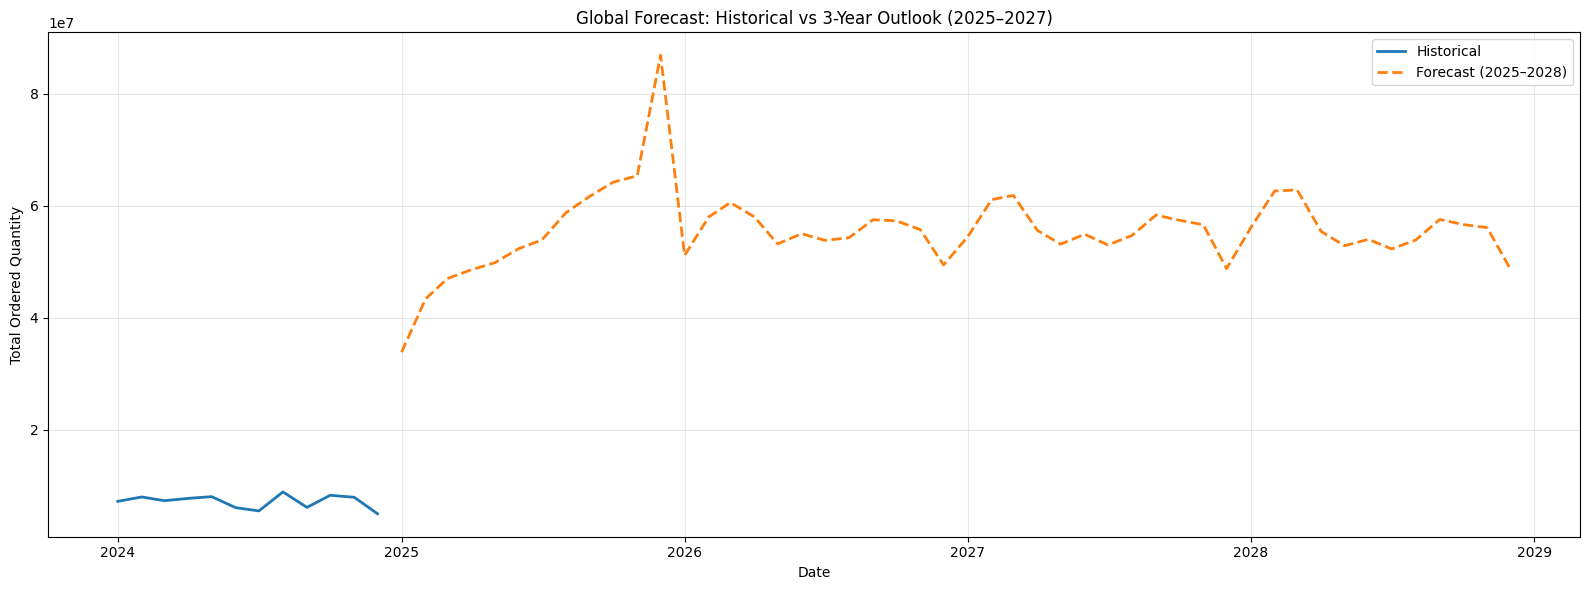

In [ ]:
plt.figure(figsize=(16, 6))

plt.plot(hist_agg['PO_CREATED_DATE'], hist_agg['ORDERED_QUANTITY'], 
         label="Historical", linewidth=2)

plt.plot(fut_agg['PO_CREATED_DATE'], fut_agg['ORDERED_QUANTITY'],
         label="Forecast (2025–2028)", linewidth=2, linestyle='--')

plt.title("Global Forecast: Historical vs 3-Year Outlook (2025–2027)")
plt.xlabel("Date")
plt.ylabel("Total Ordered Quantity")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


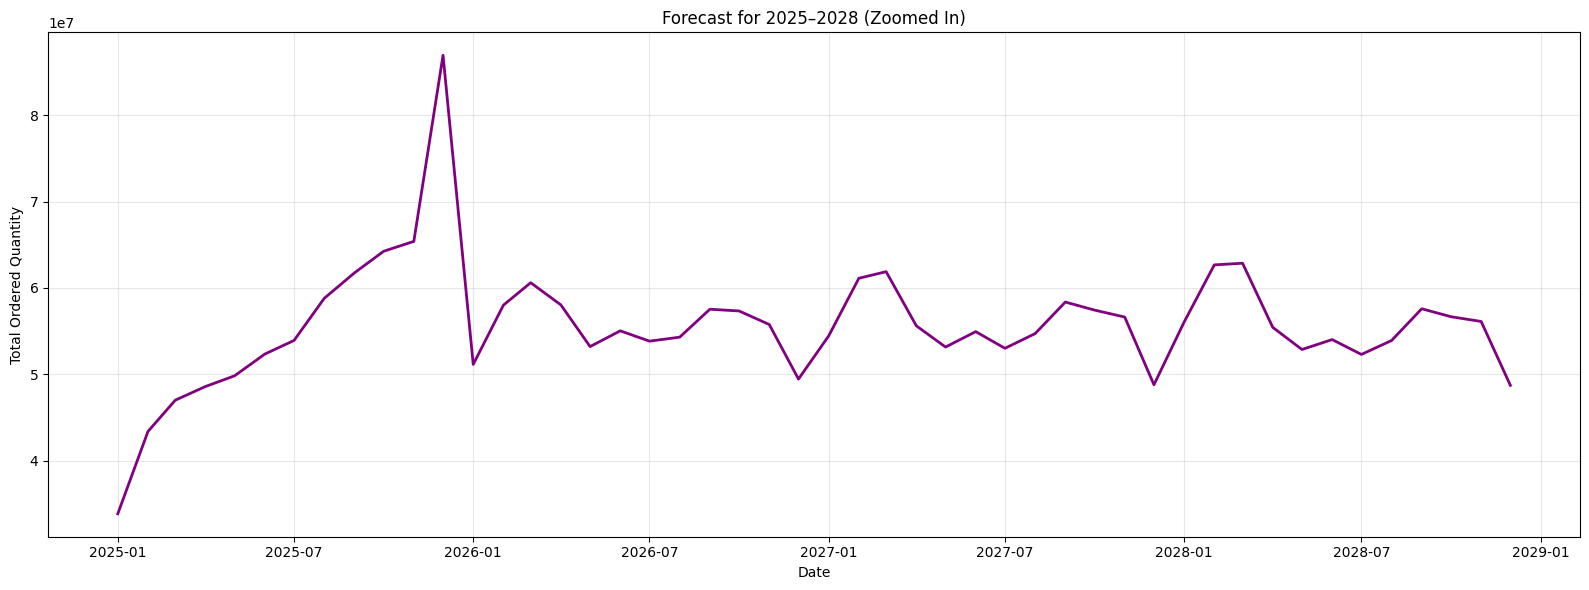

In [ ]:
plt.figure(figsize=(16, 6))

plt.plot(fut_agg['PO_CREATED_DATE'], fut_agg['ORDERED_QUANTITY'],
         label="Future Forecast", linewidth=2, color='purple')

plt.title("Forecast for 2025–2028 (Zoomed In)")
plt.xlabel("Date")
plt.ylabel("Total Ordered Quantity")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
forecast

,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,PREDICTED
135320,2025-01-01,3,10,15,3,0,9,2,3,4,2,2391.473686
275560,2025-01-01,2,6,7,3,0,9,2,3,1,2,7499.822849
135578,2025-01-01,3,10,15,3,0,9,2,3,10,3,1390.089103
280696,2025-01-01,2,6,7,3,1,13,5,3,1,1,2558.447672
311848,2025-01-01,3,10,15,0,1,3,5,3,10,5,4096.444550
...,...,...,...,...,...,...,...,...,...,...,...,...
342903,2028-12-01,3,10,15,3,1,3,5,3,10,0,16948.633623
200151,2028-12-01,0,4,4,3,1,17,5,3,10,1,8590.296453
259815,2028-12-01,1,8,9,3,1,16,5,3,2,5,7984.050914
342855,2028-12-01,3,10,15,3,1,3,5,3,2,4,3555.155354


In [ ]:
decode_map = {col: dict(enumerate(cats)) for col, cats in category_mapping.items()}
decode_map

{'REGION': {0: 'EMEA', 1: 'Emerging Markets', 2: 'Japan', 3: 'North America'},
 'COUNTRY': {0: 'AU : Australia',
  1: 'CA : Canada',
  2: 'CN : China',
  3: 'DE : Germany',
  4: 'GB : United Kingdom',
  5: 'HK : Hong Kong',
  6: 'JP : Japan',
  7: 'KR : South Korea',
  8: 'MX : Mexico',
  9: 'NZ : New Zealand',
  10: 'US : USA'},
 'SALES_ORG_NAME': {0: '5th & Ocean',
  1: 'Australia',
  2: 'Canada',
  3: 'China',
  4: 'EMEA',
  5: 'EMEA Web',
  6: 'German',
  7: 'Japan',
  8: 'Latin America',
  9: 'Mexico',
  10: 'NEC China Shanghai',
  11: 'New Zealand',
  12: 'South Korea',
  13: 'Southeast Asia',
  14: 'US Retail',
  15: 'United States'},
 'FABRIC_TYPE': {0: 'Knits', 1: 'Other', 2: 'Polyester', 3: 'Wovens'},
 'SEASON_CONSOLIDATION': {0: 'Custom', 1: 'Program', 2: 'Stock'},
 'MARKET_SEGMENT': {0: 'ACCESSORIES',
  1: 'ACTION',
  2: 'APPAREL',
  3: 'CAP MACHINE',
  4: 'COLLEGE',
  5: 'CORPORATE',
  6: 'EK',
  7: 'EMBELLISHMENT',
  8: 'ENTERTAINMENT',
  9: 'FANGEAR',
  10: 'FOOTBALL - O

In [ ]:
for col, mapping in decode_map.items():
    if col in forecast.columns:
        forecast[col] = forecast[col].map(mapping)


In [ ]:
forecast

,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,PREDICTED
135320,2025-01-01,North America,US : USA,United States,Wovens,Custom,FANGEAR,FEMALE,Headwear,COLLEGE,920,2391.473686
275560,2025-01-01,Japan,JP : Japan,Japan,Wovens,Custom,FANGEAR,FEMALE,Headwear,BASEBALL,920,7499.822849
135578,2025-01-01,North America,US : USA,United States,Wovens,Custom,FANGEAR,FEMALE,Headwear,FOOTBALL,940,1390.089103
280696,2025-01-01,Japan,JP : Japan,Japan,Wovens,Program,LIFESTYLE,MALE,Headwear,BASEBALL,5950,2558.447672
311848,2025-01-01,North America,US : USA,United States,Knits,Program,CAP MACHINE,MALE,Headwear,FOOTBALL,Other,4096.444550
...,...,...,...,...,...,...,...,...,...,...,...,...
342903,2028-12-01,North America,US : USA,United States,Wovens,Program,CAP MACHINE,MALE,Headwear,FOOTBALL,3930,16948.633623
200151,2028-12-01,EMEA,GB : United Kingdom,EMEA,Wovens,Program,ON FIELD,MALE,Headwear,FOOTBALL,5950,8590.296453
259815,2028-12-01,Emerging Markets,MX : Mexico,Mexico,Wovens,Program,ON COURT,MALE,Headwear,BASKETBALL,Other,7984.050914
342855,2028-12-01,North America,US : USA,United States,Wovens,Program,CAP MACHINE,MALE,Headwear,BASKETBALL,950,3555.155354


In [ ]:
forecast = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/forecast_global_2025_to_2028_v3.csv')
forecast

,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,ORDERED_QUANTITY,predicted
0,2025-01-01,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,MALE,Headwear,RACING,Other,1500.0,2604.401179
1,2025-01-01,EMEA,DE : Germany,German,Knits,Program,FANGEAR,MALE,Headwear,RACING,Other,200.0,3220.274254
2,2025-01-01,EMEA,DE : Germany,German,Wovens,Custom,FANGEAR,MALE,Headwear,RACING,Other,2500.0,2082.684922
3,2025-01-01,EMEA,DE : Germany,German,Wovens,Program,FANGEAR,MALE,Headwear,RACING,940,2600.0,4371.364491
4,2025-01-01,EMEA,DE : Germany,German,Wovens,Program,FANGEAR,MALE,Headwear,RACING,Other,1300.0,1343.329684
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58635,2028-12-01,North America,US : USA,United States,Wovens,Program,WOMENS APPAREL - UPSTAIRS,LADIES,Apparel,FOOTBALL,Other,0.0,9458.000000
58636,2028-12-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,BASEBALL,5950,0.0,17906.000000
58637,2028-12-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,BASEBALL,950,0.0,6491.000000
58638,2028-12-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,COLLEGE,5950,0.0,18584.000000


In [ ]:
forecast.to_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/forecast_global_2025_to_2028_v3.csv', index=False)

# Upload Data to Azure Blob Storage

In [2]:
from dotenv import load_dotenv
load_dotenv()


True

In [3]:
from datetime import datetime
import pytz

def get_time():
    ny_tz = pytz.timezone("America/New_York")
    current_time = datetime.now(ny_tz).strftime("%Y%m%d_%H%M%S")
    return current_time

import os
from azure.storage.blob import BlobServiceClient

connect_str = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
# Create the BlobServiceClient object
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

## Puchase Predictions Upload and Download

In [3]:
container_purchase = blob_service_client.get_container_client('predictions-predictions')

### Upload Purchase Predictions

In [4]:
current_time = get_time()
local_file_purchase_prediction = '/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/titans_forecast_purchase_2025-2028_updated.csv'
azure_purchase_prediction_name = f"purchase_predictions_2025_2028_{current_time}.csv"

blob_client_purchase_prediction = blob_service_client.get_blob_client(container='predictions-purchase', blob=azure_purchase_prediction_name)

print("\nUploading to Azure Storage as blob:\n\t" + azure_purchase_prediction_name)

# Upload the created file
with open(file=local_file_purchase_prediction, mode="rb") as data:
    blob_client_purchase_prediction.upload_blob(data)


Uploading to Azure Storage as blob:
	purchase_predictions_2025_2028_20251215_221705.csv


## Purchase Historical Upload and Download

In [4]:
container_purchase_historical = blob_service_client.get_container_client('purchase-historical')


### Upload data to Blob Purchase Historical

In [5]:
current_time = get_time()
local_file_purchase_historical = '/home/azureuser/cloudfiles/code/Users/vlavanga/data/historical_data/titans_purchase_historical.csv'
azure_purchase_historical_file_name = f"purchase_historical_{current_time}.csv"

blob_client_purchase_historical = blob_service_client.get_blob_client(container='purchase-historical', blob=azure_purchase_historical_file_name)

print("\nUploading to Azure Storage as blob:\n\t" + azure_purchase_historical_file_name)

# Upload the created file
with open(file=local_file_purchase_historical, mode="rb") as data:
    blob_client_purchase_historical.upload_blob(data)


Uploading to Azure Storage as blob:
	purchase_historical_20251216_123724.csv


### Download data to Blob Purchase Historical

In [ ]:
local_path_historical = './historical_data/'
os.makedirs(local_path_historical, exist_ok=True)

# List blobs in Purchase Historical
blob_list = list(container_purchase_historical.list_blobs())
latest_purchase_historical_blob = max(blob_list, key=lambda b: b.last_modified)
print("Latest Purchase Historical file:", latest_purchase_historical_blob.name)

# Define Downloaded file name
local_file_name = f'purchase_historical.csv'
download_path_purchase_historical = local_path_historical + local_file_name

# Download the latest purchase historical blob
with open(file=download_path_purchase_historical, mode="wb") as download_file:
    download_file.write(container_purchase_historical.download_blob(latest_purchase_historical_blob.name).readall())

Latest Purchase Historical file: purchase_historical_20251208_003210.csv


## Sales Historical Upload and Download

In [5]:
container_sales_historical = blob_service_client.get_container_client('sales-historical')

### Upload Sales Historical Data

In [6]:
current_time = get_time()
local_file_sales_historical = '/home/azureuser/cloudfiles/code/Users/vlavanga/data/historical_data/titans_sales_historical.csv'
azure_sales_historical_file_name = f"sales_historical_{current_time}.csv"

blob_client_sales_historical = blob_service_client.get_blob_client(container='sales-historical', blob=azure_sales_historical_file_name)

print("\nUploading to Azure Storage as blob:\n\t" + azure_sales_historical_file_name)

# Upload the created file
with open(file=local_file_sales_historical, mode="rb") as data:
    blob_client_sales_historical.upload_blob(data)


Uploading to Azure Storage as blob:
	sales_historical_20251216_110702.csv


## Sales Predictions Load and Download

In [12]:
container_sales = blob_service_client.get_container_client('predictions-sales')

### Upload sales predicitons

In [13]:
current_time = get_time()
local_file_sales_prediction = '/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/titans_forecast_2025-2028_updated.csv'
azure_sales_prediction_name = f"sales_predictions_2025_2028_{current_time}.csv"

blob_client_sales_prediction = blob_service_client.get_blob_client(container='predictions-sales', blob=azure_sales_prediction_name)

print("\nUploading to Azure Storage as blob:\n\t" + azure_sales_prediction_name)

# Upload the created file
with open(file=local_file_sales_prediction, mode="rb") as data:
    blob_client_sales_prediction.upload_blob(data)


Uploading to Azure Storage as blob:
	sales_predictions_2025_2028_20251211_142204.csv


### Download Data for Sales Predictions

In [4]:
local_path = './predicted_data/'
os.makedirs(local_path, exist_ok=True)

# Download and return Sales
blob_list = list(container_sales.list_blobs())
latest_sales_blob = max(blob_list, key=lambda b: b.last_modified)
print("Latest Sales file:", latest_sales_blob.name)

local_file_name = f'latest_predictions_sales_test.csv'
download_path_sales = local_path + local_file_name

with open(file=download_path_sales, mode="wb") as download_file:
    download_file.write(container_sales.download_blob(latest_sales_blob.name).readall())

Latest Sales file: sales_forecast_2025_2028_20251207_192758.csv


## OpenAi Data Upload and Download

In [110]:
container_open_ai = blob_service_client.get_container_client('openai-data')

### Upload OpenAI Data

In [127]:
current_time = get_time()
local_file_openai_df = '/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/openai_df_v2.csv'
azure_openai_df_name = f"openai_df_2026_2028_{current_time}.csv"

blob_client_openai_df = blob_service_client.get_blob_client(container='openai-data', blob=azure_openai_df_name)

print("\nUploading to Azure Storage as blob:\n\t" + azure_openai_df_name)

# Upload the created file
with open(file=local_file_openai_df, mode="rb") as data:
    blob_client_openai_df.upload_blob(data)


Uploading to Azure Storage as blob:
	openai_df_2026_2028_20251210_025637.csv


### Download OpenAI

In [ ]:
local_path = './predicted_data/'
os.makedirs(local_path, exist_ok=True)

# Download and return Sales
blob_list = list(container_open_ai.list_blobs())
latest_openai_blob = max(blob_list, key=lambda b: b.last_modified)
print("Latest Sales file:", latest_openai_blob.name)

local_file_name = f'latest_openai_dataset.csv'
download_path_openai = local_path + local_file_name

with open(file=download_path_openai, mode="wb") as download_file:
    download_file.write(container_open_ai.download_blob(latest_openai_blob.name).readall())

# Fix Purchase Data

In [27]:
df = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/forecast_global_2025_to_2028_v5.csv')
len(df)

58640

In [31]:
cols = df.columns.tolist()

for col in cols:
    try:
        df[col] = df[col].replace('NONE', 'Other')
    except:
        pass
    try:
        df[col] = df[col].replace('Unknown', 'Other')
    except:
        df[col] = df[col].replace('UNKNOWN', 'Other')


In [32]:
df['SPORT_UPDATED'].unique()

array(['RACING', 'GOLF', 'SOCCER', 'CRICKET', 'FOOTBALL', 'BASEBALL',
       'ENTERTAINMENT', 'BASKETBALL', 'HOCKEY', 'Other', 'TENNIS',
       'RUGBY', 'CORE', 'COLLEGE', 'LACROSSE', 'NON LICENSED', 'BOXING',
       'ANIMATED CHARACTER', 'WATER SPORTS', 'SNOWSPORTS', 'E SPORT'],
      dtype=object)

In [33]:
df.to_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/forecast_global_2025_to_2028_v4.csv', index=False)

In [ ]:
df_pur = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/forecast_global_2025_to_2028_v4.csv')
df_pur = df_pur['PO_CREATED_DATE', "OREDERED_QUANTITY", "predicted"]
df_pur = df_pur.groupby(['PO_CREATED_DATE']).agg({'OREDERED_QUANTITY':'sum', 'predicted':'sum'}).reset_index()


# Fix Sales Data

In [1]:
import pandas as pd

In [2]:
df_sales_read = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/titans_sales_updated.csv')
df_sales_read.head(1)

,DATE,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,ACTUAL_SALES,FORECAST_P50,FORECAST_P05,FORECAST_P95,CI_LOWER,CI_UPPER,CI_WIDTH,FORECAST_YEAR
0,2025-01-01,EMEA,Germany,Others,940,Male,Others,6110.0,7193.628874,5941.799986,8197.389182,5941.799986,8197.389182,2255.589196,2025


In [ ]:
df_sales_read = df_sales_read[df_sales_read['MONTH_START'] >= '2025-01-01']

conditions = df_sales_read['MONTH_START'] >= '2025-12-01'
df_sales_read.loc[conditions, 'actual'] = np.nan
df_sales_read

,REGION,COUNTRY,SALES_ORG,FABRIC_TYPE_CLASS,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT,SILHOUETTE,MONTH_START,actual,predicted
2630016,EMEA,GB : United Kingdom,EMEA Web,Polyester,LIFESTYLE,FEMALE,Headwear,ENTERTAINMENT,5950,2025-01-01,0.0,102.876956
2630017,Emerging Markets,NZ : New Zealand,New Zealand,Woven,FANGEAR,FEMALE,Headwear,Others,920,2025-01-01,0.0,102.983825
2630018,Emerging Markets,NZ : New Zealand,New Zealand,Woven,LIFESTYLE,FEMALE,Headwear,BASEBALL,Other,2025-01-01,0.0,102.983714
2630019,Emerging Markets,HK : Hong Kong,Southeast Asia,Polyester,LIFESTYLE,MALE,Headwear,BASEBALL,940,2025-01-01,601.0,502.114859
2630020,Emerging Markets,HK : Hong Kong,Southeast Asia,Woven,FANGEAR,BOYS,Headwear,BASKETBALL,Other,2025-01-01,0.0,102.974973
...,...,...,...,...,...,...,...,...,...,...,...,...
3287515,North America,CA : Canada,Canada,Polyester,MENS APPAREL,BOYS,Apparel,FOOTBALL,APPAREL,2028-12-01,NaN,399.327841
3287516,North America,CA : Canada,Canada,Polyester,MENS APPAREL,BOYS,Apparel,BASKETBALL,APPAREL,2028-12-01,NaN,399.330412
3287517,North America,CA : Canada,Canada,Polyester,MENS APPAREL,BOYS,Apparel,BASEBALL,APPAREL,2028-12-01,NaN,399.371890
3287518,North America,CA : Canada,Canada,Polyester,LIFESTYLE,MALE,Headwear,WRESTLING,950,2028-12-01,NaN,402.732308


In [18]:
df_sales_read.to_csv('/home/azureuser/cloudfiles/code/Users/moizuddi/sales_predictions_v4.csv')

In [9]:
import numpy as np
values = np.isnan(df_sales_read['actual'].unique())

In [13]:
for val in values:
    if val == True:
        print("There are missing values in the 'actual' column.")
        

In [59]:
df_sales_not_2025 = df_sales_read[df_sales_read['MONTH_START'] > '2025-12-01']
df_sales_2025 = df_sales_read[(df_sales_read['MONTH_START'] >= '2025-01-01') & (df_sales_read['MONTH_START'] < '2025-12-01')]

df_sales_dec = df_sales_read[df_sales_read['MONTH_START'] == '2025-12-01']
df_sales_dec = df_sales_dec.drop(columns=['Type'])

df_actual_sales = df_sales_2025[df_sales_2025['Type'] == 'Actual']
df_prediction_sales = df_sales_2025[df_sales_2025['Type'] == 'Predicted']

df_actual_sales['actual'] = df_actual_sales['TOTAL_SALES_QTY']
df_actual_sales = df_actual_sales.drop(columns=['TOTAL_SALES_QTY','Type'])

df_prediction_sales['predicted'] = df_prediction_sales['TOTAL_SALES_QTY']
df_prediction_sales = df_prediction_sales.drop(columns=['TOTAL_SALES_QTY', 'Type'])

/tmp/ipykernel_4196/3223666629.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual_sales['actual'] = df_actual_sales['TOTAL_SALES_QTY']
/tmp/ipykernel_4196/3223666629.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_sales['predicted'] = df_prediction_sales['TOTAL_SALES_QTY']


In [61]:
df_sales_dec['actual'] = np.nan
df_sales_dec['predicted'] = df_sales_dec['TOTAL_SALES_QTY']
df_sales_dec = df_sales_dec.drop(columns=['TOTAL_SALES_QTY'])

In [62]:
list_cols_sales = df_actual_sales.columns.tolist()
list_cols_sales.remove('actual')

list_cols_sales_pred = df_prediction_sales.columns.tolist()
list_cols_sales_pred.remove('predicted')

In [63]:
df_actual_sales = df_actual_sales.sort_values(by=list_cols_sales_pred)
df_prediction_sales = df_prediction_sales.sort_values(by=list_cols_sales_pred)

In [64]:
df_fixed_2025 = df_actual_sales.copy()
df_fixed_2025['predicted'] = df_prediction_sales['predicted'].values 

In [65]:
df_fixed_2025

,REGION,COUNTRY,SALES_ORG,FABRIC_TYPE_CLASS,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT,SILHOUETTE,MONTH_START,actual,predicted
0,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-01-01,0.0,102.961369
2,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-02-01,0.0,102.946020
4,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-03-01,0.0,103.268424
6,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-04-01,0.0,102.964465
8,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-05-01,0.0,102.657614
...,...,...,...,...,...,...,...,...,...,...,...,...
822072,North America,US : USA,United States,Woven,WOMENS APPAREL - UPSTAIRS,YOUTH,Apparel,SOCCER,APPAREL,2025-07-01,0.0,102.946798
822074,North America,US : USA,United States,Woven,WOMENS APPAREL - UPSTAIRS,YOUTH,Apparel,SOCCER,APPAREL,2025-08-01,0.0,102.952873
822076,North America,US : USA,United States,Woven,WOMENS APPAREL - UPSTAIRS,YOUTH,Apparel,SOCCER,APPAREL,2025-09-01,0.0,102.949830
822078,North America,US : USA,United States,Woven,WOMENS APPAREL - UPSTAIRS,YOUTH,Apparel,SOCCER,APPAREL,2025-10-01,0.0,102.959765


In [66]:
df_sales_not_2025.head(1)
df_sales_not_2025['predicted'] = df_sales_not_2025['TOTAL_SALES_QTY']

/tmp/ipykernel_4196/1492217566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales_not_2025['predicted'] = df_sales_not_2025['TOTAL_SALES_QTY']


In [67]:
import numpy as np
df_sales_not_2025 = df_sales_not_2025.drop(columns=['TOTAL_SALES_QTY','Type'])
df_sales_not_2025['actual'] = np.nan

In [68]:
df_final = pd.concat([df_fixed_2025, df_sales_not_2025, df_sales_dec], axis=0)
df_final = df_final.sort_values(by=list_cols_sales_pred)
df_final

,REGION,COUNTRY,SALES_ORG,FABRIC_TYPE_CLASS,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT,SILHOUETTE,MONTH_START,actual,predicted
0,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-01-01,0.0,102.961369
2,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-02-01,0.0,102.946020
4,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-03-01,0.0,103.268424
6,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-04-01,0.0,102.964465
8,EMEA,DE : Germany,German,Knit,ACTION,MALE,Headwear,BASEBALL,Other,2025-05-01,0.0,102.657614
...,...,...,...,...,...,...,...,...,...,...,...,...
822115,North America,US : USA,United States,Woven,WOMENS APPAREL - UPSTAIRS,YOUTH,Apparel,SOCCER,APPAREL,2028-08-01,NaN,377.703832
822116,North America,US : USA,United States,Woven,WOMENS APPAREL - UPSTAIRS,YOUTH,Apparel,SOCCER,APPAREL,2028-09-01,NaN,373.554341
822117,North America,US : USA,United States,Woven,WOMENS APPAREL - UPSTAIRS,YOUTH,Apparel,SOCCER,APPAREL,2028-10-01,NaN,394.672162
822118,North America,US : USA,United States,Woven,WOMENS APPAREL - UPSTAIRS,YOUTH,Apparel,SOCCER,APPAREL,2028-11-01,NaN,407.389655


In [69]:
df_final.to_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/sales_forecast_2025_to_2028_fixed_v2.csv', index=False)

In [ ]:
df_final = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/sales_forecast_2025_to_2028_fixed_v2.csv')
columns = df_final.columns.tolist()
remove_list. = ['']
columns
df_final = df_final.groupby(['MONTH_START', 'REGION', 'COUNTRY', 'SPORT_UPDATED', 'PRODUCT_CATEGORY', 'PRODUCT_SUBCATEGORY']).agg({'actual':'sum', 'predicted':'sum'}).reset_index()

In [4]:
import pandas as pd
df_check_hist = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/historical_data/titans_purchase_historical.csv')
df_chsk = df_check_hist[df_check_hist['REGION'] == 'Unknown']
df_check_hist.head()

,REGION,COUNTRY,SALESORG,SILHOUETTE,PRODUCT_DIVISION,GENDER,SPORT,SEASON,MONTH,YEAR,PURCHASE_COUNT
0,Emerging Markets,South Korea,South Korea,S-5950,Headwear,Male,SP-None,Program,5,2020,180.0
1,Emerging Markets,South Korea,South Korea,S-5950,Headwear,Male,Basketball,Program,12,2020,72.0
2,Emerging Markets,South Korea,South Korea,S-950,Headwear,Male,Baseball,Program,4,2013,700.0
3,North America,USA,United States,S-920,Headwear,Others,SP-None,Custom,11,2017,1.0
4,EMEA,United Kingdom,EMEA,Others,Headwear,Others,Baseball,Program,7,2019,144.0


In [11]:
df_check_hist['PURCHASE_COUNT'].sum()

1703235349.846

In [2]:
import pandas as pd
df_check = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/Falcons-NEC/predicted_data/latest_predictions_purchase.csv')
df_check

,REGION,COUNTRY,SALESORG,SILHOUETTE_UPDATED,GENDER,SPORT_UPDATED,SEASON_CONSOLIDATION,PO_CREATED_DATE,predicted,ORDERED_QUANTITY,FORECAST_P05,FORECAST_P95
0,EMEA,Germany,German,Apparel,Male,Others,Program,2025-08-01,4.613424e+02,1435.0,3.690739e+02,5.536109e+02
1,EMEA,Germany,German,Apparel,Male,Others,Program,2026-01-01,4.615993e+02,NaN,3.692794e+02,5.539191e+02
2,EMEA,Germany,German,Apparel,Male,Others,Program,2026-02-01,1.518659e+03,NaN,1.214927e+03,1.822390e+03
3,EMEA,Germany,German,Apparel,Male,Others,Program,2026-03-01,1.461426e+03,NaN,1.169141e+03,1.753712e+03
4,EMEA,Germany,German,Apparel,Male,Others,Program,2026-04-01,7.352379e+02,NaN,5.881903e+02,8.822855e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
98243,Unknown,Unknown,Unknown,Others,Others,Others,UNASSIGNED,2028-08-01,5.294473e+06,NaN,4.235579e+06,6.353368e+06
98244,Unknown,Unknown,Unknown,Others,Others,Others,UNASSIGNED,2028-09-01,5.205680e+06,NaN,4.164544e+06,6.246816e+06
98245,Unknown,Unknown,Unknown,Others,Others,Others,UNASSIGNED,2028-10-01,5.465297e+06,NaN,4.372237e+06,6.558356e+06
98246,Unknown,Unknown,Unknown,Others,Others,Others,UNASSIGNED,2028-11-01,5.430024e+06,NaN,4.344020e+06,6.516029e+06


# Test OpenAI Api

In [1]:
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

OPEN_AI_API_KEY = os.getenv('OPENAI_API_KEY')

## Purchase Historical

In [3]:
import pandas as pd
df_hist = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/historical_data/titans_purchase_historical.csv')
df_hist.head(2)

,REGION,COUNTRY,SALESORG,SILHOUETTE,PRODUCT_DIVISION,GENDER,SPORT,SEASON,MONTH,YEAR,PURCHASE_COUNT
0,Emerging Markets,South Korea,South Korea,5950,Headwear,Male,Others,Program,5,2020,180.0
1,Emerging Markets,South Korea,South Korea,5950,Headwear,Male,Basketball,Program,12,2020,72.0


In [8]:
categorical_cols = [
    "SPORT",
    "SEASON",
    "GENDER",
    "SILHOUETTE"
]
for features in categorical_cols:
    print(features, df_hist[features].unique())

SPORT ['Others' 'Basketball' 'Baseball' 'Football' 'College']
SEASON ['Program' 'Custom' 'Stock' 'Others']
GENDER ['Male' 'Others' 'Boys' 'Girls' 'Ladies']
SILHOUETTE ['5950' '950' '920' 'Others' '940' '3930' 'Apparel']


In [ ]:
import pandas as pd
import numpy as np

def build_historical_summary(
    df: pd.DataFrame,
    categorical_features: list,
    target_col: str = "PURCHASE_COUNT"
):
    """
    Builds an LLM-friendly driver summary from historical data.
    
    Parameters
    ----------
    df : pd.DataFrame
        Historical dataset
    categorical_features : list
        List of categorical column names (e.g. ['SPORT','SEASON','GENDER'])
    target_col : str
        Target variable (default = PURCHASE_COUNT)

    Returns
    -------
    dict
        Compact driver summary for LLM consumption
    """

    summary_grp = {}
    summary_main = {}
    total_demand = df[target_col].sum()

    
    for feature in categorical_features:
        
        grp = (
            df.groupby(feature)[target_col]
            .sum()
            .reset_index()
        )
        grp = grp[grp[feature] != 'Others']
        
        feature_values = grp[feature].unique()

        for grp_val in feature_values:
            grp_df = grp[grp[feature] == grp_val]

            avg_val = grp_df[target_col].mean()
            std_val = grp_df[target_col].std()
            share_pct = (grp_df[target_col].sum() / total_demand) * 100

            # Relative strength (based on share of demand)
            if share_pct > 60:
                strength = "high"
            elif share_pct > 25:
                strength = "medium"
            else:
                strength = "low"
            
            # Variation (coefficient of variation)
            cv = std_val / avg_val if avg_val > 0 else 0
            if cv > 1:
                variation = "high"
            elif cv > 0.4:
                variation = "medium"
            else:
                variation = "low"

            
            summary_grp[grp_val] = {
                "avg_purchase": round(float(avg_val), 2),
                "share_of_demand_pct": round(float(share_pct), 1),
                "relative_strength": strength,
                "variation": variation
            }
        summary_main[feature] = summary_grp

    return summary_main


In [11]:
categorical_cols = [
    "SPORT",
    "SEASON",
    "GENDER",
    "SILHOUETTE"
]

driver_summary = build_driver_summary(
    df=df_hist,
    categorical_features=categorical_cols,
    target_col="PURCHASE_COUNT"
)
driver_summary

{'SPORT': {'Baseball': {'avg_purchase': 263130160.0,
   'share_of_demand_pct': 15.4,
   'relative_strength': 'low',
   'variation': 'low'},
  'Basketball': {'avg_purchase': 39853522.0,
   'share_of_demand_pct': 2.3,
   'relative_strength': 'low',
   'variation': 'low'},
  'College': {'avg_purchase': 22348125.0,
   'share_of_demand_pct': 1.3,
   'relative_strength': 'low',
   'variation': 'low'},
  'Football': {'avg_purchase': 83002538.0,
   'share_of_demand_pct': 4.9,
   'relative_strength': 'low',
   'variation': 'low'},
  'Custom': {'avg_purchase': 411499181.0,
   'share_of_demand_pct': 24.2,
   'relative_strength': 'low',
   'variation': 'low'},
  'Program': {'avg_purchase': 129572053.0,
   'share_of_demand_pct': 7.6,
   'relative_strength': 'low',
   'variation': 'low'},
  'Stock': {'avg_purchase': 47241435.0,
   'share_of_demand_pct': 2.8,
   'relative_strength': 'low',
   'variation': 'low'},
  'Boys': {'avg_purchase': 22813740.0,
   'share_of_demand_pct': 1.3,
   'relative_stren

In [16]:
def build_historical_insight_prompt(summary_dict, level="row"):
    return f"""
You are a supply-chain demand forecasting analyst.

You are given a compact historical driver summary derived from purchase data.
Each driver includes:
- avg_purchase: average demand contribution
- share_of_demand_pct: share of total demand
- relative_strength: high / medium / low
- variation: high / medium / low

HISTORICAL DRIVER SUMMARY:
{summary_dict}

TASK:
Generate a clear, concise, business-friendly explanation of demand drivers.

INSTRUCTIONS:
1. Identify the strongest and weakest demand drivers.
2. Explain how each key driver influences demand in plain language.
3. Highlight drivers with high variation as potential planning risks.
4. Avoid technical or statistical jargon.
5. Do NOT repeat the raw numbers unless necessary.
6. Focus on interpretation and business impact, not data processing.
7. Keep the response to 5–8 sentences.

OUTPUT FORMAT:
Write a short narrative paragraph suitable for supply-chain planners and business stakeholders.
"""


In [17]:
from openai import OpenAI

categorical_cols = [
    "SPORT",
    "SEASON",
    "GENDER",
    "SILHOUETTE"
]

driver_summary = build_driver_summary(
    df=df_hist,
    categorical_features=categorical_cols,
    target_col="PURCHASE_COUNT"
)


def get_openai_client():
    #OPEN_AI_API_KEY = st.secrets['OPENAI_API_KEY']
    OPEN_AI_API_KEY = os.getenv('OPEN_AI_API_KEY')
    client = OpenAI()

    return client

def generate_llm_review(summary_dict, type, level="row", model="gpt-4.1-mini"):

    client = get_openai_client()

    if type == 'Historical':
        prompt = build_historical_insight_prompt(summary_dict, level)
    elif type == 'Forecast':
        prompt = build_insight_prompt(summary_dict, level)

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an expert at communicating with non-tech Supply Chain and Business Stake holder."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )

    # Updated: use .content instead of ["content"]
    return response.choices[0].message.content


group_insight = generate_llm_review(driver_summary, type='Historical', level="group")
print(group_insight)


The demand is primarily driven by the "Male" segment, which holds the strongest influence on overall purchases, indicating that products targeted toward this group contribute significantly to sales. In contrast, categories like "Girls" and "Ladies" show much weaker demand, suggesting lower sales impact. Most demand drivers exhibit low variation, meaning demand is relatively stable and predictable, which supports reliable planning. Since no drivers show high variation, there are minimal immediate risks related to sudden demand fluctuations. Overall, focusing on the key segments with medium to low strength but stable demand will help optimize inventory and meet customer needs effectively.


## Purchase Predictions

In [39]:
df = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/predictions/forecast_global_2025_to_2028_v5.csv')
df.head(2)

,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,ORDERED_QUANTITY,predicted,shap_summary
0,2025-01-01,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,MALE,Headwear,RACING,Other,1500.0,2149,NaN
1,2025-01-01,EMEA,DE : Germany,German,Knits,Program,FANGEAR,MALE,Headwear,RACING,Other,200.0,3203,NaN


In [26]:
openai_df = df[df['PO_CREATED_DATE'] >= '2026-01-01']
openai_df.to_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/openai_df_v2.csv', index=False)

In [40]:
import pandas as pd
openai_df = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/openai_df_v2.csv')
openai_df.head(2)

,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,ORDERED_QUANTITY,predicted,shap_summary
0,2026-01-01,EMEA,DE : Germany,German,Knits,Custom,FANGEAR,MALE,Headwear,RACING,Other,NaN,2297,{'top_positive': {'months_since_start': 1384.8...
1,2026-01-01,EMEA,DE : Germany,German,Knits,Program,FANGEAR,MALE,Headwear,RACING,Other,NaN,2283,{'top_positive': {'months_since_start': 1300.5...


In [41]:
filtered_df = openai_df[(openai_df['PO_CREATED_DATE'] >= '2026-01-01') & (openai_df['PO_CREATED_DATE'] <= '2026-04-01')]

filtered_df.tail()

,PO_CREATED_DATE,REGION,COUNTRY,SALES_ORG_NAME,FABRIC_TYPE,SEASON_CONSOLIDATION,MARKET_SEGMENT,GENDER,DIVISION_NAME,SPORT_UPDATED,SILHOUETTE_UPDATED,ORDERED_QUANTITY,predicted,shap_summary
5165,2026-04-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,FOOTBALL,950,NaN,6675,{'top_positive': {'months_since_start': 2084.3...
5166,2026-04-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,NONE,5950,NaN,16271,{'top_positive': {'months_since_start': 3024.7...
5167,2026-04-01,North America,US : USA,United States,Wovens,Stock,LIFESTYLE,MALE,Headwear,NONE,950,NaN,5058,{'top_positive': {'months_since_start': 2186.3...
5168,2026-04-01,North America,US : USA,United States,Wovens,Stock,ON FIELD,BOYS,Headwear,BASEBALL,Other,NaN,6985,{'top_positive': {'months_since_start': 2754.5...
5169,2026-04-01,North America,US : USA,United States,Wovens,Stock,ON FIELD,MALE,Headwear,BASEBALL,Other,NaN,9769,{'top_positive': {'months_since_start': 2829.2...


In [42]:
categorical_features = [
    'Knits', 'Wovens', 'Other',
   'FANGEAR', 'LIFESTYLE', 'GOLF', 'MENS APPAREL', 'ON FIELD',
       'WOMENS APPAREL - UPSTAIRS', 'ACCESSORIES', 'Unknown',
       'WOMENS APPAREL - MASS', 'CORPORATE', 'APPAREL', 'TEAM EQUIPMENT',
       'KIDS', 'CAP MACHINE', 'COLLEGE', 'ACTION', 'NEW ERA BRANDED',
       'ON COURT','MALE', 'BOYS', 'FEMALE', 'LADIES', 'Unknown', 'GIRLS','RACING', 'GOLF', 'SOCCER', 'CRICKET', 'FOOTBALL', 'BASEBALL',
       'BASKETBALL', 'HOCKEY', 'NONE', 'Unknown',
       'TENNIS', 'RUGBY', 'CORE', 'COLLEGE', 'LACROSSE', 'NON LICENSED',
       'BOXING', 'ANIMATED CHARACTER',
    'Custom', 'Program', 'Stock'
]



In [43]:
def compute_group_overview(filtered_df):

    pos_driver_list = []
    pos_value_list = []
    neg_driver_list = []
    neg_value_list = []
    magnitude_list = []

    for shap in filtered_df["shap_summary"]:

        # 🔥 FIX 1: Convert whole shap object from str → dict
        if isinstance(shap, str):
            try:
                shap = ast.literal_eval(shap)
            except:
                continue  # skip bad rows

        # 🔥 FIX 2: Extract and convert their subfields safely
        top_pos = shap.get("top_positive", {})
        top_neg = shap.get("top_negative", {})

        if isinstance(top_pos, str):
            try:
                top_pos = ast.literal_eval(top_pos)
            except:
                top_pos = {}

        if isinstance(top_neg, str):
            try:
                top_neg = ast.literal_eval(top_neg)
            except:
                top_neg = {}

        # --- Extract top positive drivers ---
        for feat, val in top_pos.items():
            pos_driver_list.append(feat)
            pos_value_list.append(val)

        # --- Extract top negative drivers ---
        for feat, val in top_neg.items():
            neg_driver_list.append(feat)
            neg_value_list.append(val)

        # Magnitude
        magnitude_list.append(shap.get("shap_magnitude", 0))

    # Handle empty lists gracefully
    if not pos_driver_list or not neg_driver_list:
        return {
            "dominant_positive_driver": None,
            "avg_positive_influence": 0,
            "dominant_negative_driver": None,
            "avg_negative_influence": 0,
            "avg_shap_magnitude": float(np.mean(magnitude_list)) if magnitude_list else 0
        }

    # --- Summary Computation ---
    dominant_pos = pd.Series(pos_driver_list).value_counts().idxmax()
    dominant_neg = pd.Series(neg_driver_list).value_counts().idxmax()

    avg_pos_value = float(np.mean([v for f, v in zip(pos_driver_list, pos_value_list) if f == dominant_pos]))
    avg_neg_value = float(np.mean([v for f, v in zip(neg_driver_list, neg_value_list) if f == dominant_neg]))

    avg_magnitude = float(np.mean(magnitude_list))

    return {
        "dominant_positive_driver": dominant_pos,
        "avg_positive_influence": avg_pos_value,
        "dominant_negative_driver": dominant_neg,
        "avg_negative_influence": avg_neg_value,
        "avg_shap_magnitude": avg_magnitude
    }

In [44]:
group_summary = compute_group_overview(filtered_df)
print(group_summary)

{'dominant_positive_driver': None, 'avg_positive_influence': 0, 'dominant_negative_driver': None, 'avg_negative_influence': 0, 'avg_shap_magnitude': 0}


In [20]:
def build_insight_prompt(summary_dict, level="row"):
    return f"""
You are an AI assistant helping to explain machine learning demand forecasting outputs.
The model is LightGBM, and SHAP values show the contribution of each feature to the forecast.

### CONTEXT
- SHAP positive values increase the forecast.
- SHAP negative values decrease the forecast.
- SHAP magnitude indicates the overall influence and volatility of the prediction.

### TASK
Provide a clear, simple, business-friendly explanation of the forecast drivers.

### INPUT (SHAP SUMMARY)
{summary_dict}

### INSTRUCTIONS
1. Summarize the most important positive and negative drivers.
2. Give a simple explanation of how these features relate to increased or decreased demand.
3. For group-level summaries, explain the general behavior of the segment or year.
4. Avoid technical jargon.
5. Keep it concise but meaningful.

### OUTPUT
A business-friendly explanation.
"""


In [25]:
from openai import OpenAI
def get_openai_client():
    #OPEN_AI_API_KEY = st.secrets['OPENAI_API_KEY']
    OPEN_AI_API_KEY = os.getenv('OPEN_AI_API_KEY')
    client = OpenAI()

    return client

def generate_llm_review(summary_dict, level="row", model="gpt-4.1-mini"):

    client = get_openai_client()
    prompt = build_insight_prompt(summary_dict, level)

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an expert at explaining machine learning forecast drivers simply and clearly."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )

    # Updated: use .content instead of ["content"]
    return response.choices[0].message.content


group_insight = generate_llm_review(group_summary, level="group")
print(group_insight)


The forecast shows that the time since the product or service started (months since start) is the main factor pushing demand higher, contributing an average increase of about 1,794 units. On the other hand, the 12-month rolling average of past demand (rollmean_12) is the strongest factor pulling the forecast down, reducing demand by around 2,635 units on average. Overall, the forecast is influenced by several factors, with some causing significant ups and downs. This suggests that while demand tends to grow as the product matures, recent longer-term trends are currently signaling a slowdown or dip in demand.


In [ ]:
import time
import streamlit as st

def typewriter(text, speed=0.01):
    placeholder = st.empty()
    typed = ""
    for char in text:
        typed += char
        placeholder.markdown(typed)
        time.sleep(speed)

typewriter(group_insight)

In [126]:
df_test_oai = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/openai_df_v2.csv')
df_test_oai

,PO_CREATED_DATE,REGION,SALES_ORG_NAME,SILHOUETTE_UPDATED,shap_summary
0,2026-01-01,EMEA,German,Other,{'top_positive': {'months_since_start': 1384.8...
1,2026-01-01,EMEA,German,Other,{'top_positive': {'months_since_start': 1300.5...
2,2026-01-01,EMEA,German,Other,{'top_positive': {'months_since_start': 1409.6...
3,2026-01-01,EMEA,German,940,{'top_positive': {'months_since_start': 1311.8...
4,2026-01-01,EMEA,German,Other,{'top_positive': {'months_since_start': 1295.5...
...,...,...,...,...,...
43975,2028-12-01,North America,United States,Other,{'top_positive': {'months_since_start': 4235.7...
43976,2028-12-01,North America,United States,5950,{'top_positive': {'SILHOUETTE_UPDATED': 4518.1...
43977,2028-12-01,North America,United States,950,{'top_positive': {'SEASON_CONSOLIDATION': 2042...
43978,2028-12-01,North America,United States,5950,{'top_positive': {'months_since_start': 2315.0...
